# Importing Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import preprocessing
import numpy as np
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1 Choosing Data
### 1.1 Background
There are 671 basins in the dataset. Initially, we want to focus initially on one basin for visualisation and model training, before expanding our training dataset to multiple basins. 

### 1.2 Choosing initial basin
We will use 4 different variables to select our first dataset; `Runoff`, `Precipitation`,`Slope`, and `Size`. We first sort the basins in order of highest `Runoff`*`Precipitation`. We then choose the basins which have `Slope`/`Size` > 3.5. Based on this criteria, we have ascertained that `BASIN_ID` = 14138900 is the most suitable for initial training. 

### 1.3 Subsequent basin
We will then continue model training on 10% of the other basins based on the above criteria.

In [ ]:
# Importing hydrometeorology and physical characteristic data
df_hydro_char = pd.read_csv("/content/drive/MyDrive/203N_Data/basin_annual_hydrometeorology_characteristics_daymet.txt", sep='\s+')
df_phy_char = pd.read_csv("/content/drive/MyDrive/203N_Data/basin_physical_characteristics.txt", sep='\s+')

# Creating the desired criteria columns
df_hydro_char['Runoff * Precip'] = df_hydro_char['Runoff(mm_day-1)'] * df_hydro_char['Precip(mm_day-1)']
df_phy_char['slope/size']=df_phy_char['Slope(m_km-1)']/df_phy_char['Size(km2)']

# Combining both dataframes and sorting
basin_char = pd.concat([df_hydro_char,df_phy_char],axis=1)
basin_char.sort_values('Runoff * Precip')[(basin_char['slope/size']>3.5) & (basin_char['Runoff(mm_day-1)']<basin_char['Precip(mm_day-1)'])].tail(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


BASIN_HUC  BASIN_ID  Runoff(mm_day-1)  Precip(mm_day-1)  PET(mm_day-1)  \
173          3   2384540             2.184             4.820          2.783   
37           2   1434025             2.743             4.479          2.263   
575         17  12377150             3.795             4.079          2.454   
661         18  11475560             3.500             5.226          2.827   
623         17  14306340             4.232             6.325          2.831   
621         17  14303200             5.410             6.618          2.078   
569         17  12178100             6.279             6.335          1.993   
604         17  14138800             6.630             7.752          2.075   
605         17  14138870             6.110             8.424          2.097   
606         17  14138900             8.311             8.978          2.108   

     Temp(oC)  Runoff * Precip  BASIN_HUC  BASIN_ID  Size(km2)  Elevation(m)  \
173    13.168        10.526880          3   2384540      22.13        499.46   
37      5.686        12.285897          2   1434025       9.90        729.33   
575     1.957        15.479805         17  12377150      32.39       1512.07   
661     9.699        18.291000         18  11475560      16.87        592.58   
623     9.213        26.767400         17  14306340      14.76        397.44   
621     8.500        35.803380         17  14303200       8.07        572.22   
569     4.166        39.777465         17  12178100      72.60       1305.01   
604     6.866        51.395760         17  14138800      21.83        821.62   
605     7.481        51.470640         17  14138870      15.34        727.80   
606     7.478        74.616158         17  14138900      21.99        757.32   

     Slope(m_km-1)  Frac_Forest(percent)  slope/size  
173       93.55977                0.9600    4.227735  
37        59.40710                1.0000    6.000717  
575      129.59930                0.8676    4.001213  
661       90.33273                0.9922    5.354637  
623       62.50098                0.9933    4.234484  
621       70.81645                1.0000    8.775273  
569      255.68840                0.9211    3.521879  
604      142.23871                1.0000    6.515745  
605      122.18566                1.0000    7.965167  
606       93.62395                1.0000    4.257569

# 2 Importing Data
Given the above critera, we shall import data from `BASIN_ID` = 14138900 

In [ ]:
df_x_raw = pd.read_csv("/content/drive/MyDrive/203N_Data/14138900_lump_cida_forcing_leap.txt", sep='\s+')
df_y_raw = pd.read_csv("/content/drive/MyDrive/203N_Data/14138900_streamflow_qc.txt", sep='\s+', names=["ID", "YearX", "MonthX", "DayX","Streamflow(mm3/s)","Data Availability"])


In [ ]:
# df_x_raw = pd.read_csv("14138900_lump_cida_forcing_leap.txt", sep='\s+')
# df_y_raw = pd.read_csv("14138900_streamflow_qc.txt", sep='\s+', names=["ID", "YearX", "MonthX", "DayX","Streamflow(mm3/s)","Data Availability"])


# 3 Data Pre-Processing

### 3.1 Combining Predictor and Target Variables into one Dataframe
We also rename the columns for ease of typing. We have 12783 rows of data from 1980 to 2014.

In [ ]:
df_raw = pd.concat([df_x_raw, df_y_raw], axis = 1)
df_raw_dropped = df_raw.drop(['YearX', 'MonthX','DayX','Hr','ID','swe(mm)','Data Availability'], axis = 1)
df_renamed = df_raw_dropped.rename({'dayl(s)':'daylight_seconds','prcp(mm/day)':'precipitation','srad(W/m2)':'solar_radiation','swe(mm)':'snow_water_equivalent','tmax(C)':'tmax','tmin(C)':'tmin','vp(Pa)':'vapour_pressure','Streamflow(mm3/s)': 'streamflow'}, axis=1)
df_renamed


Year  Mnth  Day  daylight_seconds  precipitation  solar_radiation  \
0      1980     1    1          30758.40          27.17            59.19   
1      1980     1    2          31001.95          19.36            75.11   
2      1980     1    3          31104.00          12.57           100.62   
3      1980     1    4          31104.00          20.38            90.00   
4      1980     1    5          31104.00          22.98            58.72   
...     ...   ...  ...               ...            ...              ...   
12779  2014    12   27          30758.40           6.93            39.77   
12780  2014    12   28          30758.40          34.64            42.06   
12781  2014    12   29          30758.40          29.82           151.44   
12782  2014    12   30          30758.40           0.13           162.95   
12783  2014    12   31          30758.40           0.07           204.73   

       tmax   tmin  vapour_pressure  streamflow  
0      4.49   0.70           643.35       127.0  
1      4.68  -0.17           605.43        98.0  
2      3.54  -3.06           487.44        88.0  
3      2.88  -2.85           495.05        86.0  
4      2.06  -1.54           546.68       125.0  
...     ...    ...              ...         ...  
12779  2.75   1.06           659.97      -999.0  
12780  1.75   0.02           613.42      -999.0  
12781  0.42  -7.27           356.35      -999.0  
12782 -5.18 -10.25           280.34      -999.0  
12783 -2.14  -9.09           302.40      -999.0  

[12784 rows x 10 columns]

### 3.2 Data Cleaning
The last 2 months of 2014 have no `streamflow` data available, and hence we drop it from the data. We now have 12704 rows of data.

In [ ]:
df_cleaned = df_renamed[df_renamed.streamflow != -999]
df_cleaned

Year  Mnth  Day  daylight_seconds  precipitation  solar_radiation  \
0      1980     1    1          30758.40          27.17            59.19   
1      1980     1    2          31001.95          19.36            75.11   
2      1980     1    3          31104.00          12.57           100.62   
3      1980     1    4          31104.00          20.38            90.00   
4      1980     1    5          31104.00          22.98            58.72   
...     ...   ...  ...               ...            ...              ...   
12700  2014    10    9          39743.99           0.00           319.73   
12701  2014    10   10          39398.40           0.00           292.48   
12702  2014    10   11          39052.80           0.00           160.47   
12703  2014    10   12          39052.80          14.29           111.17   
12704  2014    10   13          38707.21           1.46           279.25   

        tmax  tmin  vapour_pressure  streamflow  
0       4.49  0.70           643.35       127.0  
1       4.68 -0.17           605.43        98.0  
2       3.54 -3.06           487.44        88.0  
3       2.88 -2.85           495.05        86.0  
4       2.06 -1.54           546.68       125.0  
...      ...   ...              ...         ...  
12700  20.42  8.28          1074.44        10.0  
12701  18.10  7.69          1035.60        11.0  
12702  12.92  7.80          1061.99        13.0  
12703  11.01  6.36           966.27        13.0  
12704  17.29  6.33           954.45        11.0  

[12705 rows x 10 columns]

### 3.3.1 Cyclical Encoding - Encoding date-based data
The current issue with the provided date data is that it does not capture the cylical nature of time. If we simply encoded the day of the month by replacing date data with numbers from 1 to 31, the model would not be able to realise that day 1 follows from day 31. Hence, we replace the `day` and `month` variables with `dayOfYear_sin` and `dayOfYear_cos`.


In [ ]:
# encoding date data

# prepare data for correlation matrix
days = [31, 28, 31, 30, 31, 30,
        31, 31, 30, 31, 30, 31];

def dayOfYear(row):
     
    # Extract the year, month and the
    # day from the date string
    year = (int)(row['Year']);
    month = (int)(row['Mnth']);
    day = (int)(row['Day']);
 
    # If current year is a leap year and the date
    # given is after the 28th of February then
    # it must include the 29th February
    if (month > 2 and year % 4 == 0 and
       (year % 100 != 0 or year % 400 == 0)):
        day += 1;
 
    # Add the days in the previous months
    month -= 1;
    while (month > 0):
        day = day + days[month - 1];
        month -= 1;
    return day;

def getSine(row):
    day_of_year = row['dayOfYear']
    return np.sin((day_of_year*2*np.pi)/366)

def getCosine(row):
    day_of_year = row['dayOfYear']
    return np.cos((day_of_year*2*np.pi)/366)    

df_encoded = df_cleaned.copy()
df_encoded['dayOfYear'] = df_encoded.apply(lambda row : dayOfYear(row), axis = 1)
df_encoded['dayOfYear_sin'] = df_encoded.apply(lambda row : getSine(row), axis = 1)
df_encoded['dayOfYear_cos'] = df_encoded.apply(lambda row : getCosine(row), axis = 1)
df_encoded.head()

Year  Mnth  Day  daylight_seconds  precipitation  solar_radiation  tmax  \
0  1980     1    1          30758.40          27.17            59.19  4.49   
1  1980     1    2          31001.95          19.36            75.11  4.68   
2  1980     1    3          31104.00          12.57           100.62  3.54   
3  1980     1    4          31104.00          20.38            90.00  2.88   
4  1980     1    5          31104.00          22.98            58.72  2.06   

   tmin  vapour_pressure  streamflow  dayOfYear  dayOfYear_sin  dayOfYear_cos  
0  0.70           643.35       127.0          1       0.017166       0.999853  
1 -0.17           605.43        98.0          2       0.034328       0.999411  
2 -3.06           487.44        88.0          3       0.051479       0.998674  
3 -2.85           495.05        86.0          4       0.068615       0.997643  
4 -1.54           546.68       125.0          5       0.085731       0.996318

### 3.3.2  Cyclical nature of data
By visualising the encoding of the month and day variables in the graph below, we can see that the cyclical nature of the data is able to shine through.

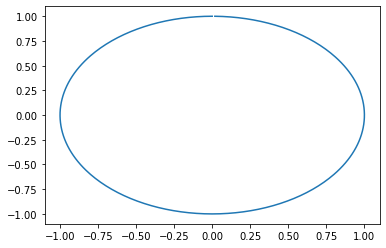

In [ ]:
plt.plot(df_encoded.loc[(df_encoded['Year']==1980)]['dayOfYear_sin'], df_encoded.loc[(df_encoded['Year']==1980) ]['dayOfYear_cos'])

### 3.5 Scaling our data and finishing preprocessing
Predictor data in our dataset have varying sizes and ranges. We need to normalise our data in order to ensure all features have the same weightage and so that our models can converge faster.


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

df_scaled = df_encoded.copy()
col_names = df_scaled.columns
cols_to_scale=['daylight_seconds', 'precipitation', 'solar_radiation', 'tmax', 'tmin','vapour_pressure','streamflow', 'dayOfYear','dayOfYear_sin','dayOfYear_cos']
ct = ColumnTransformer([("lol", preprocessing.StandardScaler(), cols_to_scale)],remainder='passthrough')
df_scaled[cols_to_scale] = ct.fit_transform(df_scaled[cols_to_scale])

df_preproc = df_scaled.drop(['Mnth', 'Day', 'dayOfYear'],axis=1)

df_preproc



Year  daylight_seconds  precipitation  solar_radiation      tmax  \
0      1980         -1.440077       1.329592        -1.566542 -0.924833   
1      1980         -1.412006       0.762317        -1.454403 -0.902104   
2      1980         -1.400244       0.269130        -1.274712 -1.038476   
3      1980         -1.400244       0.836404        -1.349519 -1.117428   
4      1980         -1.400244       1.025254        -1.569853 -1.215520   
...     ...               ...            ...              ...       ...   
12700  2014         -0.404411      -0.643883         0.268682  0.980780   
12701  2014         -0.444243      -0.643883         0.076735  0.703252   
12702  2014         -0.484076      -0.643883        -0.853133  0.083599   
12703  2014         -0.484076       0.394061        -1.200399 -0.144883   
12704  2014         -0.523908      -0.537837        -0.016456  0.606356   

           tmin  vapour_pressure  streamflow  dayOfYear_sin  dayOfYear_cos  
0     -0.391477        -0.496114    0.581178       0.019092       1.425337  
1     -0.557458        -0.628884    0.272042       0.043326       1.424711  
2     -1.108819        -1.042006    0.165443       0.067547       1.423668  
3     -1.068755        -1.015361    0.144123       0.091746       1.422208  
4     -0.818830        -0.834587    0.559858       0.115916       1.420331  
...         ...              ...         ...            ...            ...  
12700  1.054653         1.013273   -0.666026      -1.405629       0.191056  
12701  0.942092         0.877281   -0.655366      -1.402311       0.215141  
12702  0.963078         0.969681   -0.634046      -1.398580       0.239166  
12703  0.688351         0.634534   -0.634046      -1.394438       0.263123  
12704  0.682627         0.593149   -0.655366      -1.389888       0.287005  

[12705 rows x 10 columns]

# 4 Exploratory Data Analysis
### 4.1 Data Overview
After removing the `month` and `day` features and replacing them with `dayOfYear_sin` and `dayOfYear_cos`, we are left with 9 predictor features. We have one target variable, `streamflow`.

In [ ]:
df_preproc.describe()

Year  daylight_seconds  precipitation  solar_radiation  \
count  12705.000000      1.270500e+04   1.270500e+04     1.270500e+04   
mean    1996.893585     -1.649125e-16  -1.248413e-15    -5.665971e-17   
std       10.041805      1.000039e+00   1.000039e+00     1.000039e+00   
min     1980.000000     -1.440077e+00  -6.438834e-01    -1.829633e+00   
25%     1988.000000     -9.620766e-01  -6.438834e-01    -8.698273e-01   
50%     1997.000000     -6.074746e-03  -6.438834e-01    -1.270454e-01   
75%     2006.000000      9.897571e-01   3.766291e-01     8.929151e-01   
max     2014.000000      1.427925e+00   9.718858e+00     2.464204e+00   

               tmax          tmin  vapour_pressure    streamflow  \
count  1.270500e+04  1.270500e+04     1.270500e+04  1.270500e+04   
mean  -3.037930e-16  3.690694e-16     1.197171e-17  1.394573e-16   
std    1.000039e+00  1.000039e+00     1.000039e+00  1.000039e+00   
min   -3.459670e+00 -4.768025e+00    -2.390262e+00 -6.809497e-01   
25%   -8.016202e-01 -6.852822e-01    -7.339592e-01 -5.487674e-01   
50%   -1.676120e-01 -8.622553e-02    -2.277373e-01 -2.822709e-01   
75%    7.630642e-01  7.513091e-01     6.333090e-01  1.228038e-01   
max    2.832563e+00  3.094117e+00     4.928282e+00  1.948111e+01   

       dayOfYear_sin  dayOfYear_cos  
count   1.270500e+04   1.270500e+04  
mean    9.355409e-17  -6.734304e-17  
std     1.000039e+00   1.000039e+00  
min    -1.417266e+00  -1.407147e+00  
25%    -1.007980e+00  -1.005120e+00  
50%     1.909172e-02  -2.957928e-03  
75%     9.976802e-01   1.006400e+00  
max     1.406966e+00   1.425546e+00

### 4.2.1 Raw Visualisation of R/S between Features and Exponentially Weighted Moving Average of Target Variable
Before implementing any sort of complex visualisation, we want to get an intuition for what our main feature data looks like, and how it compares with the Target variable: `streamflow`.

For ease of viewing and analysis, we will convert the `streamflow` into its Exponentially Weighted Moving Average (EWMA).

Furthermore, we will focus on just the first 10 years of data, but train on the full dataset of 34 years. Insights gained from only visualising the first 10 years will be largely similar to if we were to visualise the entire dataset.

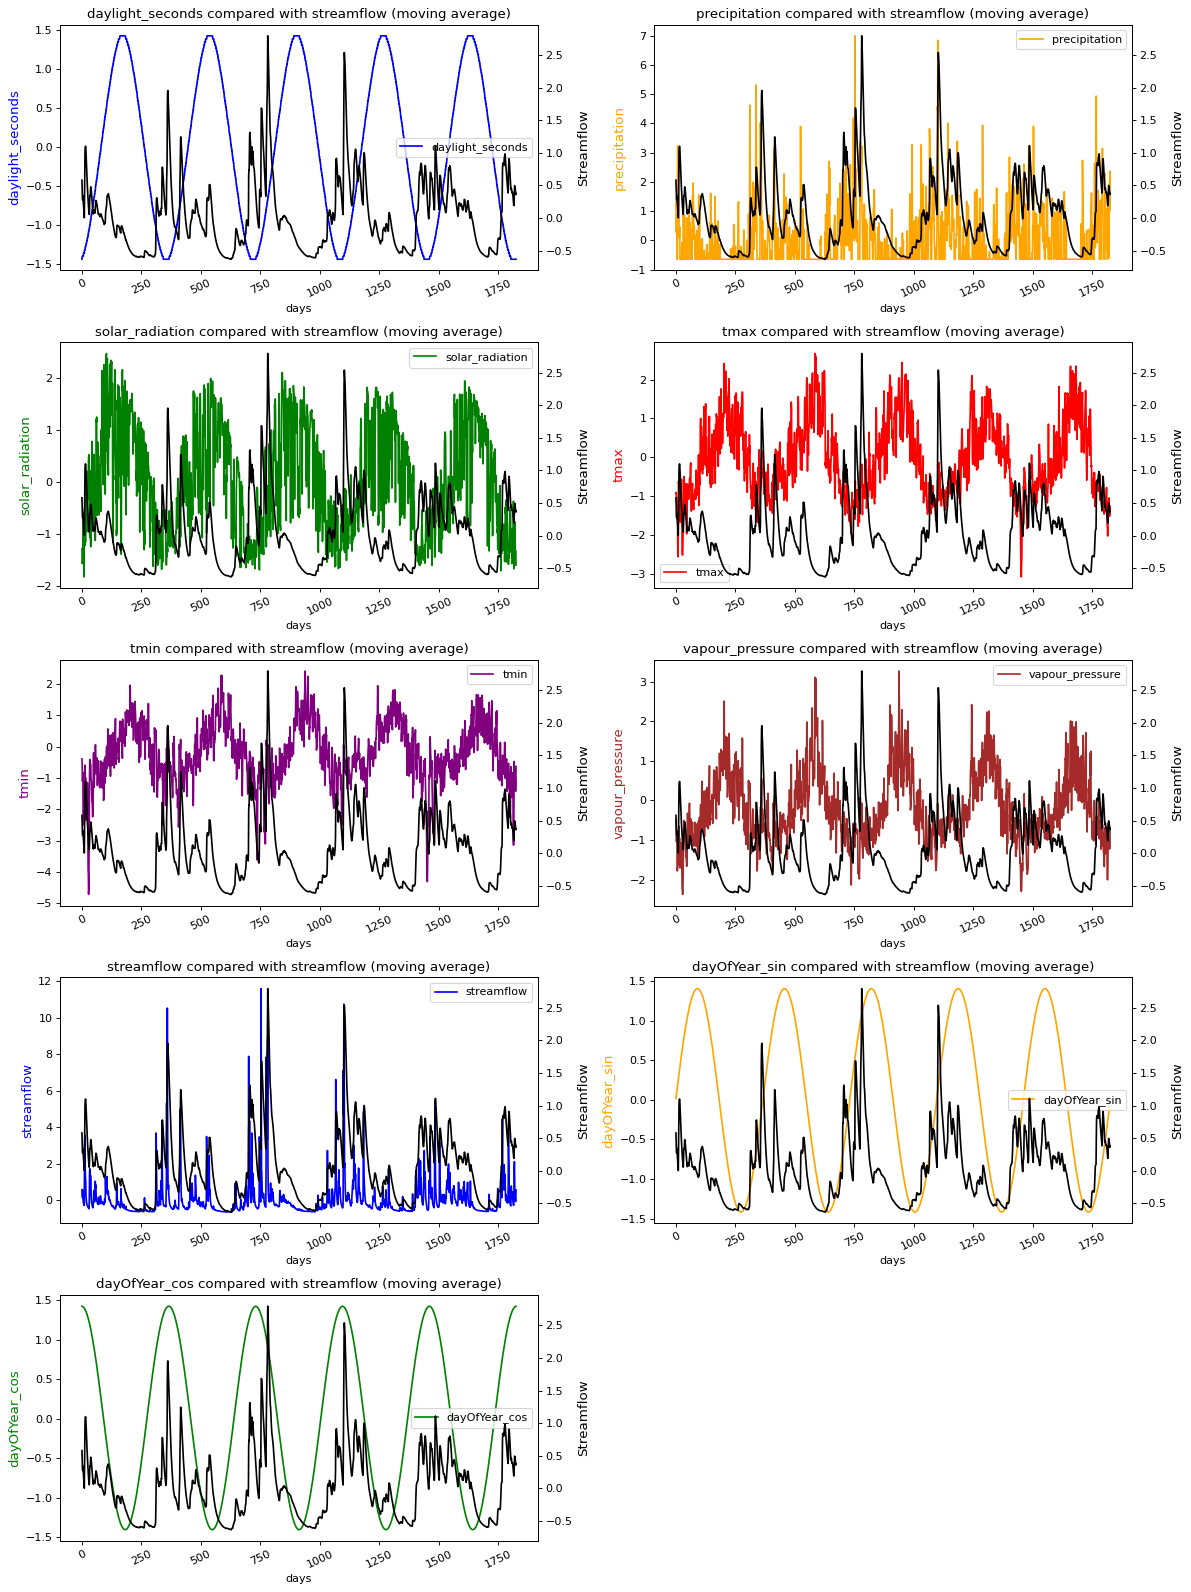

In [ ]:
df_vis = df_preproc[:1826]

def show_raw_visualization(data):
    titles = data.columns[1:10]
    feature_keys = data.columns[1:10]

    colors = [
        "blue",
        "orange",
        "green",
        "red",
        "purple",
        "brown"
#         "pink",
#         "gray",
#         "olive",
#         "cyan",
#         "maroon"
    ]

    fig, axes = plt.subplots(
        nrows=5, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
#         t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} compared with {}".format(titles[i], 'streamflow (moving average)'),
            rot=25,
        )
        ax.set_ylabel(titles[i], color=c, fontsize=12) 
        ax.set_xlabel("days")
        # Plotting the target variable,streamflow (EWMA) on each graph
        df_streamflow = data.streamflow.to_frame()
        ema = df_streamflow.ewm(alpha=0.08).mean()
        ax2=ax.twinx()
        sns.lineplot(y=ema.streamflow.to_list(), x=data.index.to_list(), ax=ax2, color='black')
        ax2.set_ylabel('Streamflow', color='black', fontsize=12) 
#         plt.plot(ema,label='streamflow')
        ax.legend([titles[i]])
    plt.tight_layout()
    fig.delaxes(axes[4][1]) # delete the last empty graph at (4,1)


show_raw_visualization(df_vis)


We can vaguely identify from the above visualisations that there is some strong alignment betwen `precipitation` and `streamflow`, where their peaks and troughs are roughly aligned. 

### 4.2.2 Closer Visualisation of Features and Target (1 Year)
We now investigate under a shorter timeframe of 1 year and 2 months to better observe characteristics. 

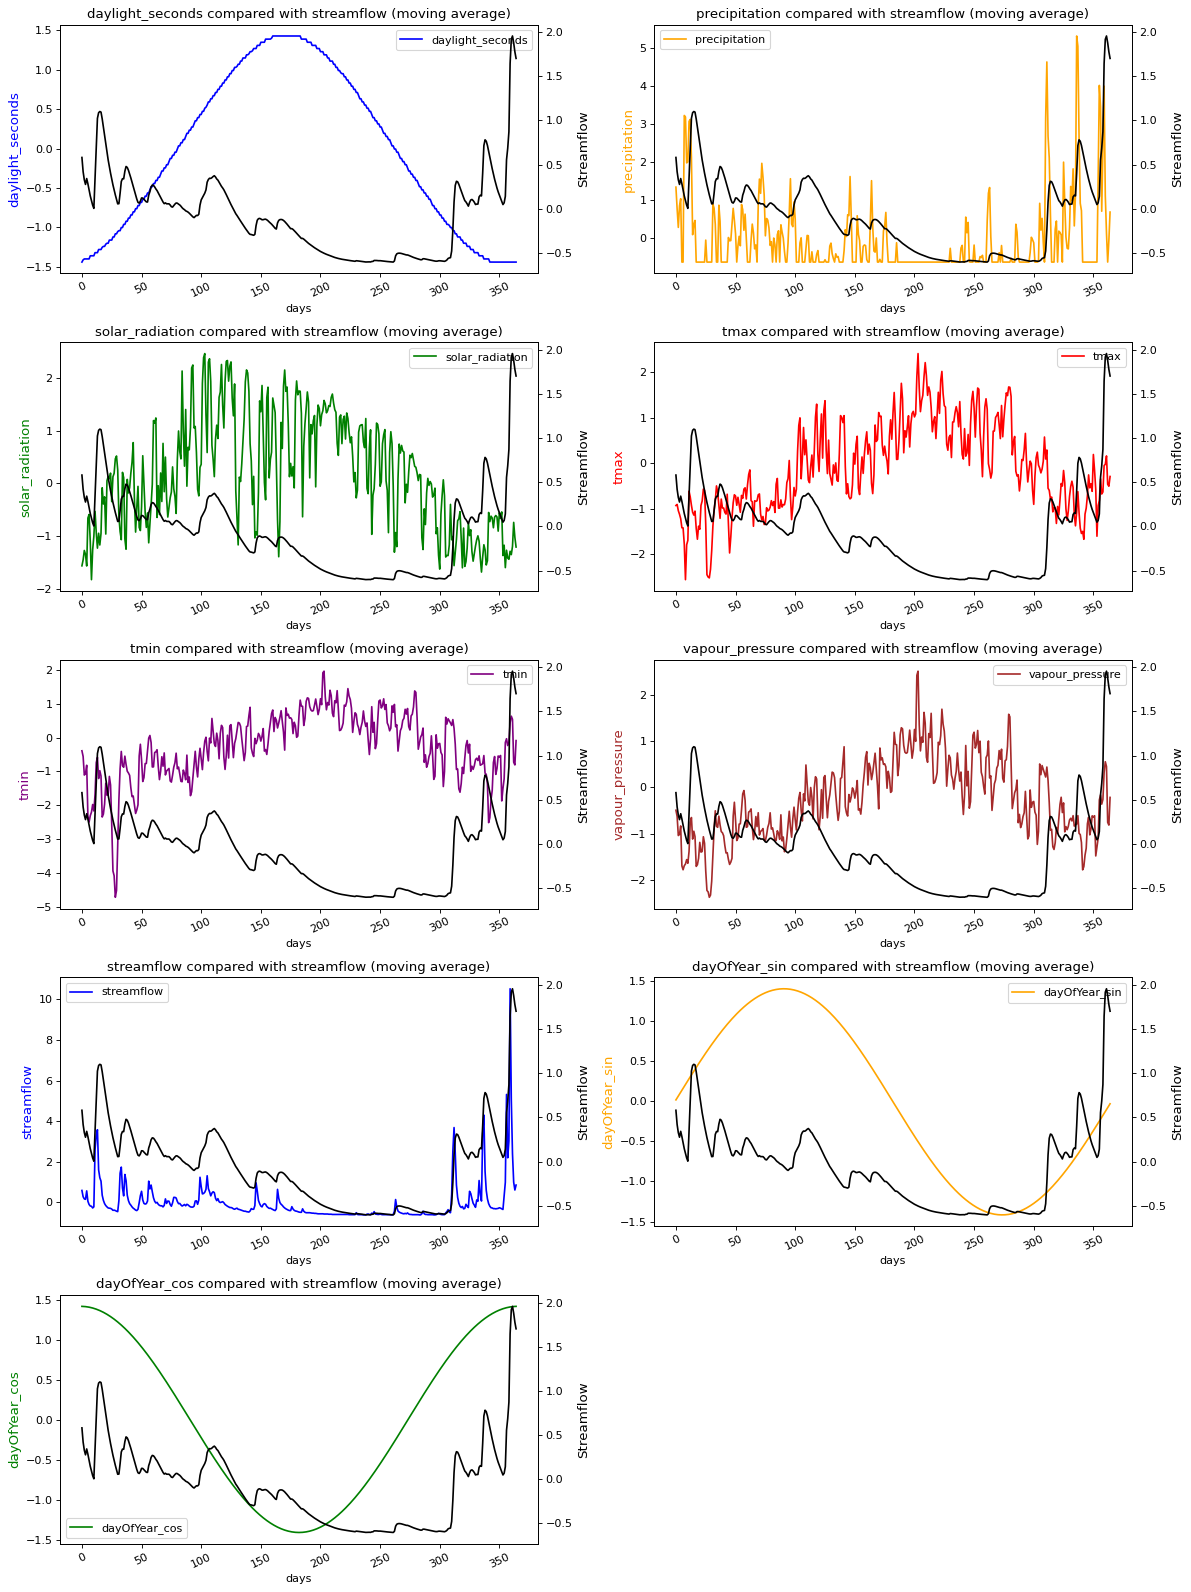

In [ ]:
df_vis1 = df_preproc[:365]
show_raw_visualization(df_vis1)

Observation of 1 year of data allows us to pick up expected trends such as low `precipitation` and `streamflow`, and high temperatures (`tmax`,`tmin`), `solar_radiation` and `daylight_seconds`. This is similar to what we expect of hot and dry months of June and July in that area due to shifts in positions of the atmospheric cells causing a prevailing westerly and north-westerly flow of air which becomes warmer and dryer as it moves inland.  

### 4.2.3 Closer Visualisation of Features and Target (2 Months)

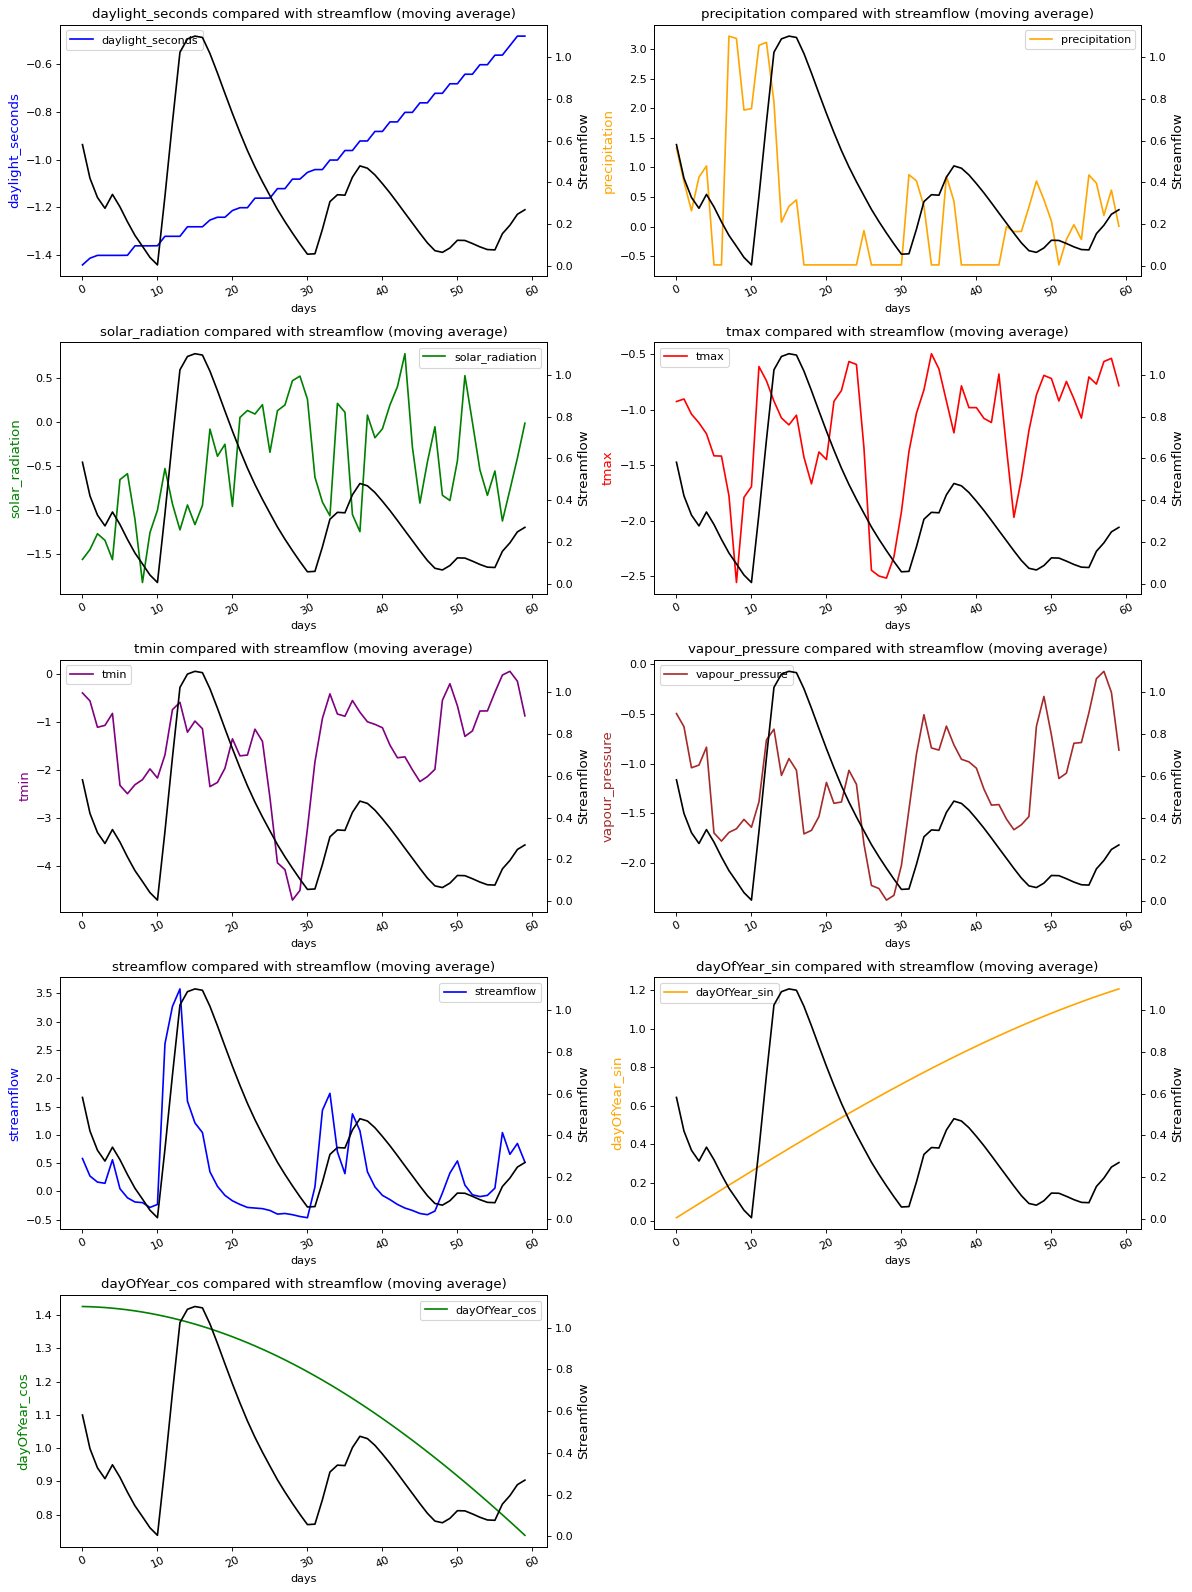

In [ ]:
df_vis2 = df_preproc[:60]
show_raw_visualization(df_vis2)

Upon closer examination of the 2 month period, we observe a notable lag time between `precipitation` and `streamflow` data in the charts. We thus attempt to create a feature of `precipitation` with potentially better correlation with the `streamflow` data by articially correcting the lag time by delaying the `precipitation` data by 1-3 days.  

### 4.2.4 Creating delayed variants of the `precipitation` feature

In [ ]:
df_pdelay = df_preproc[['precipitation','streamflow']].copy()
df_pdelay['prep_+1'] = df_pdelay['precipitation'].shift(1)
df_pdelay['prep_+2'] = df_pdelay['precipitation'].shift(2)
df_pdelay['prep_+3'] = df_pdelay['precipitation'].shift(3)
df_pdelay

precipitation  streamflow   prep_+1   prep_+2   prep_+3
0           1.329592    0.581178       NaN       NaN       NaN
1           0.762317    0.272042  1.329592       NaN       NaN
2           0.269130    0.165443  0.762317  1.329592       NaN
3           0.836404    0.144123  0.269130  0.762317  1.329592
4           1.025254    0.559858  0.836404  0.269130  0.762317
...              ...         ...       ...       ...       ...
12700      -0.643883   -0.666026 -0.643883 -0.643883 -0.643883
12701      -0.643883   -0.655366 -0.643883 -0.643883 -0.643883
12702      -0.643883   -0.634046 -0.643883 -0.643883 -0.643883
12703       0.394061   -0.634046 -0.643883 -0.643883 -0.643883
12704      -0.537837   -0.655366  0.394061 -0.643883 -0.643883

[12705 rows x 5 columns]

<Figure size 1920x1920 with 0 Axes>

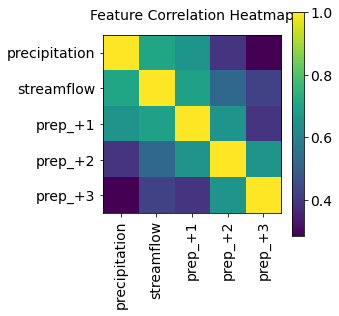

In [ ]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()

figure(figsize=(24,24), dpi=80)
show_heatmap(df_pdelay)

In the above heatmap, we observe that `precipitation` has the highest correlation to `streamflow` as compared to `precipitation` that has been delayed by 1-3 days (`prep_+1`,`prep_+2`,`prep_+3`). This shows that `precipitation` is still the best variable to use despite the observed lag between `precipitation` and `streamflow` in the visualisations. 

### 4.3 Data exploration via Pair Plots

To check the correlations of each feature with regard to the target `streamflow`, we can plot a pairplot. The diagonal graphs represent a histogram of each feature.


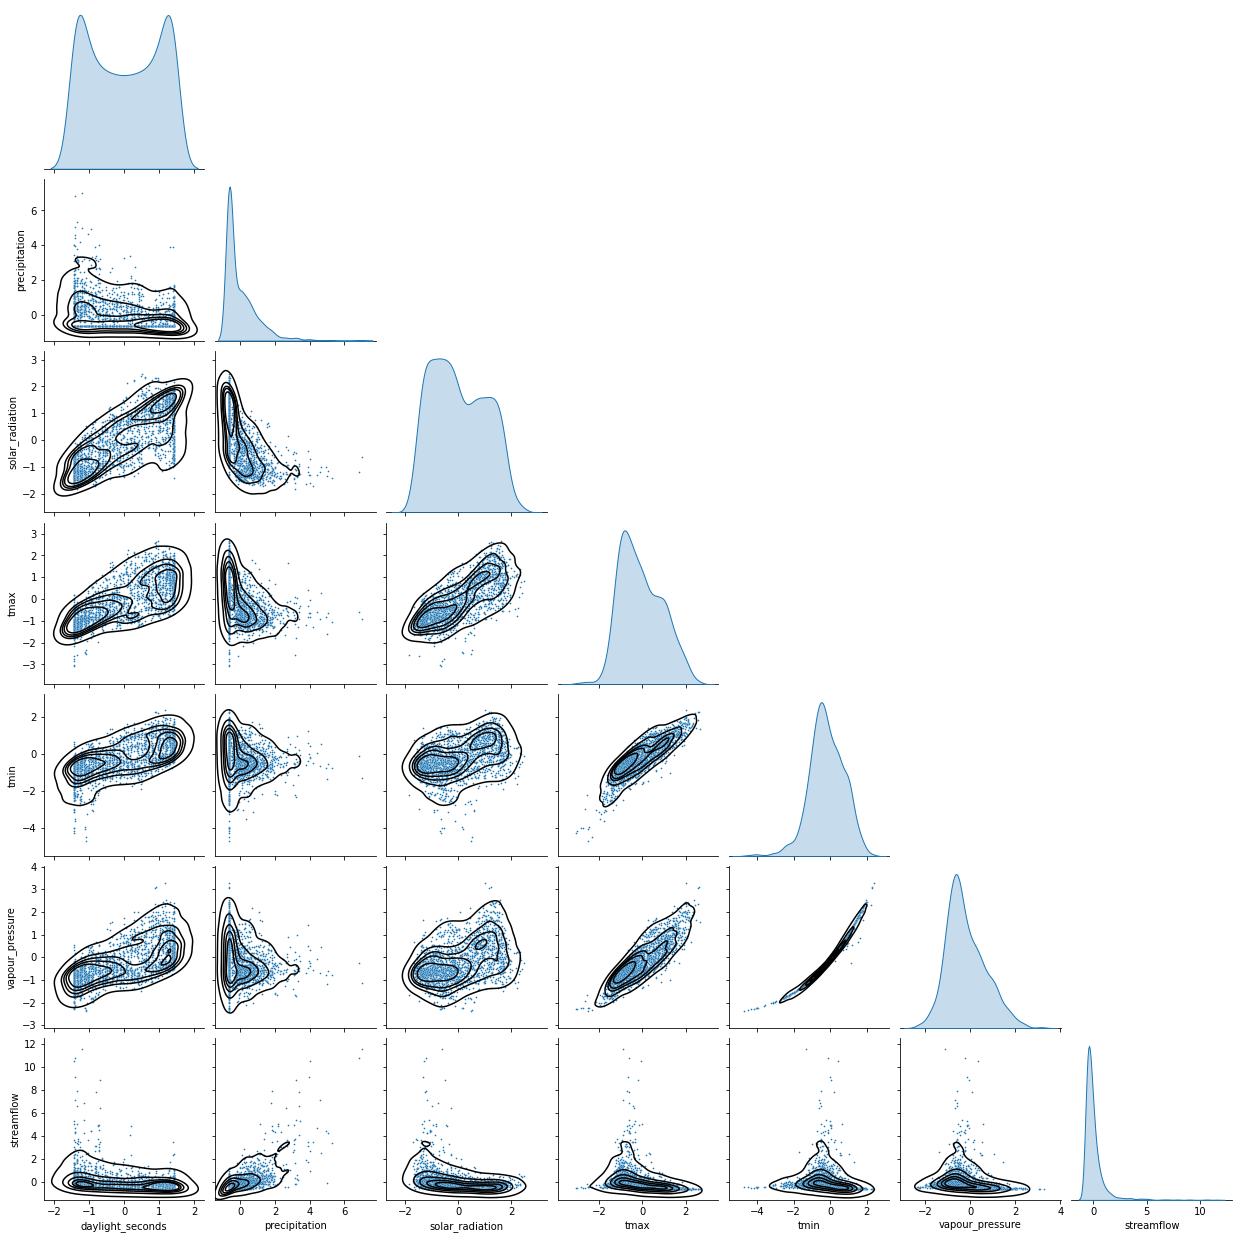

In [ ]:
titles = df_vis.columns[1:8]
df_pairplot=df_vis[titles]
p = sns.pairplot(df_pairplot,diag_kind='kde',corner=True,plot_kws={"s": 3})
p.map_lower(sns.kdeplot,levels=6, color='black')

From the scatterplots, we can ascertain that there is indeed some positive correlation between streamflow and precipitation. To quantify this correlation, we can use a correlation table and heatmap.

### 4.4 Correlation Table and Heatmap

In [ ]:
df_preproc.corr()

Year  daylight_seconds  precipitation  solar_radiation  \
Year              1.000000          0.012301       0.017659        -0.033600   
daylight_seconds  0.012301          1.000000      -0.324280         0.740810   
precipitation     0.017659         -0.324280       1.000000        -0.577360   
solar_radiation  -0.033600          0.740810      -0.577360         1.000000   
tmax              0.001512          0.682190      -0.430105         0.763163   
tmin              0.127172          0.632870      -0.222255         0.467178   
vapour_pressure   0.117079          0.624628      -0.247316         0.476590   
streamflow        0.036760         -0.288686       0.708151        -0.356197   
dayOfYear_sin     0.008774          0.179733       0.086283         0.134032   
dayOfYear_cos    -0.010865         -0.982611       0.345959        -0.728987   

                      tmax      tmin  vapour_pressure  streamflow  \
Year              0.001512  0.127172         0.117079    0.036760   
daylight_seconds  0.682190  0.632870         0.624628   -0.288686   
precipitation    -0.430105 -0.222255        -0.247316    0.708151   
solar_radiation   0.763163  0.467178         0.476590   -0.356197   
tmax              1.000000  0.883782         0.866858   -0.341097   
tmin              0.883782  1.000000         0.963780   -0.217750   
vapour_pressure   0.866858  0.963780         1.000000   -0.244895   
streamflow       -0.341097 -0.217750        -0.244895    1.000000   
dayOfYear_sin    -0.309134 -0.369703        -0.363619    0.207996   
dayOfYear_cos    -0.751933 -0.712456        -0.703002    0.331612   

                  dayOfYear_sin  dayOfYear_cos  
Year                   0.008774      -0.010865  
daylight_seconds       0.179733      -0.982611  
precipitation          0.086283       0.345959  
solar_radiation        0.134032      -0.728987  
tmax                  -0.309134      -0.751933  
tmin                  -0.369703      -0.712456  
vapour_pressure       -0.363619      -0.703002  
streamflow             0.207996       0.331612  
dayOfYear_sin          1.000000       0.004441  
dayOfYear_cos          0.004441       1.000000

<Figure size 1920x1920 with 0 Axes>

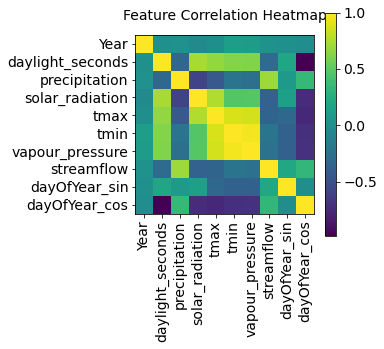

In [ ]:
figure(figsize=(24,24), dpi=80)
show_heatmap(df_preproc)

The correlation between streamflow and precipitation is 0.708, which is notably strong. This variable will be important when training our model.

### 4.5 Resampling our dataset

Downsampling our data will help change the time interval of our data. In doing so, we are aggregating daily data into weekly data, weekly data into monthly data, and so on, by means of finding the weekly mean, monthly mean, and so on.

Doing this will help us to better visualise trends in the data. It may also improve the predictive accuracy of our forecasting models later on.

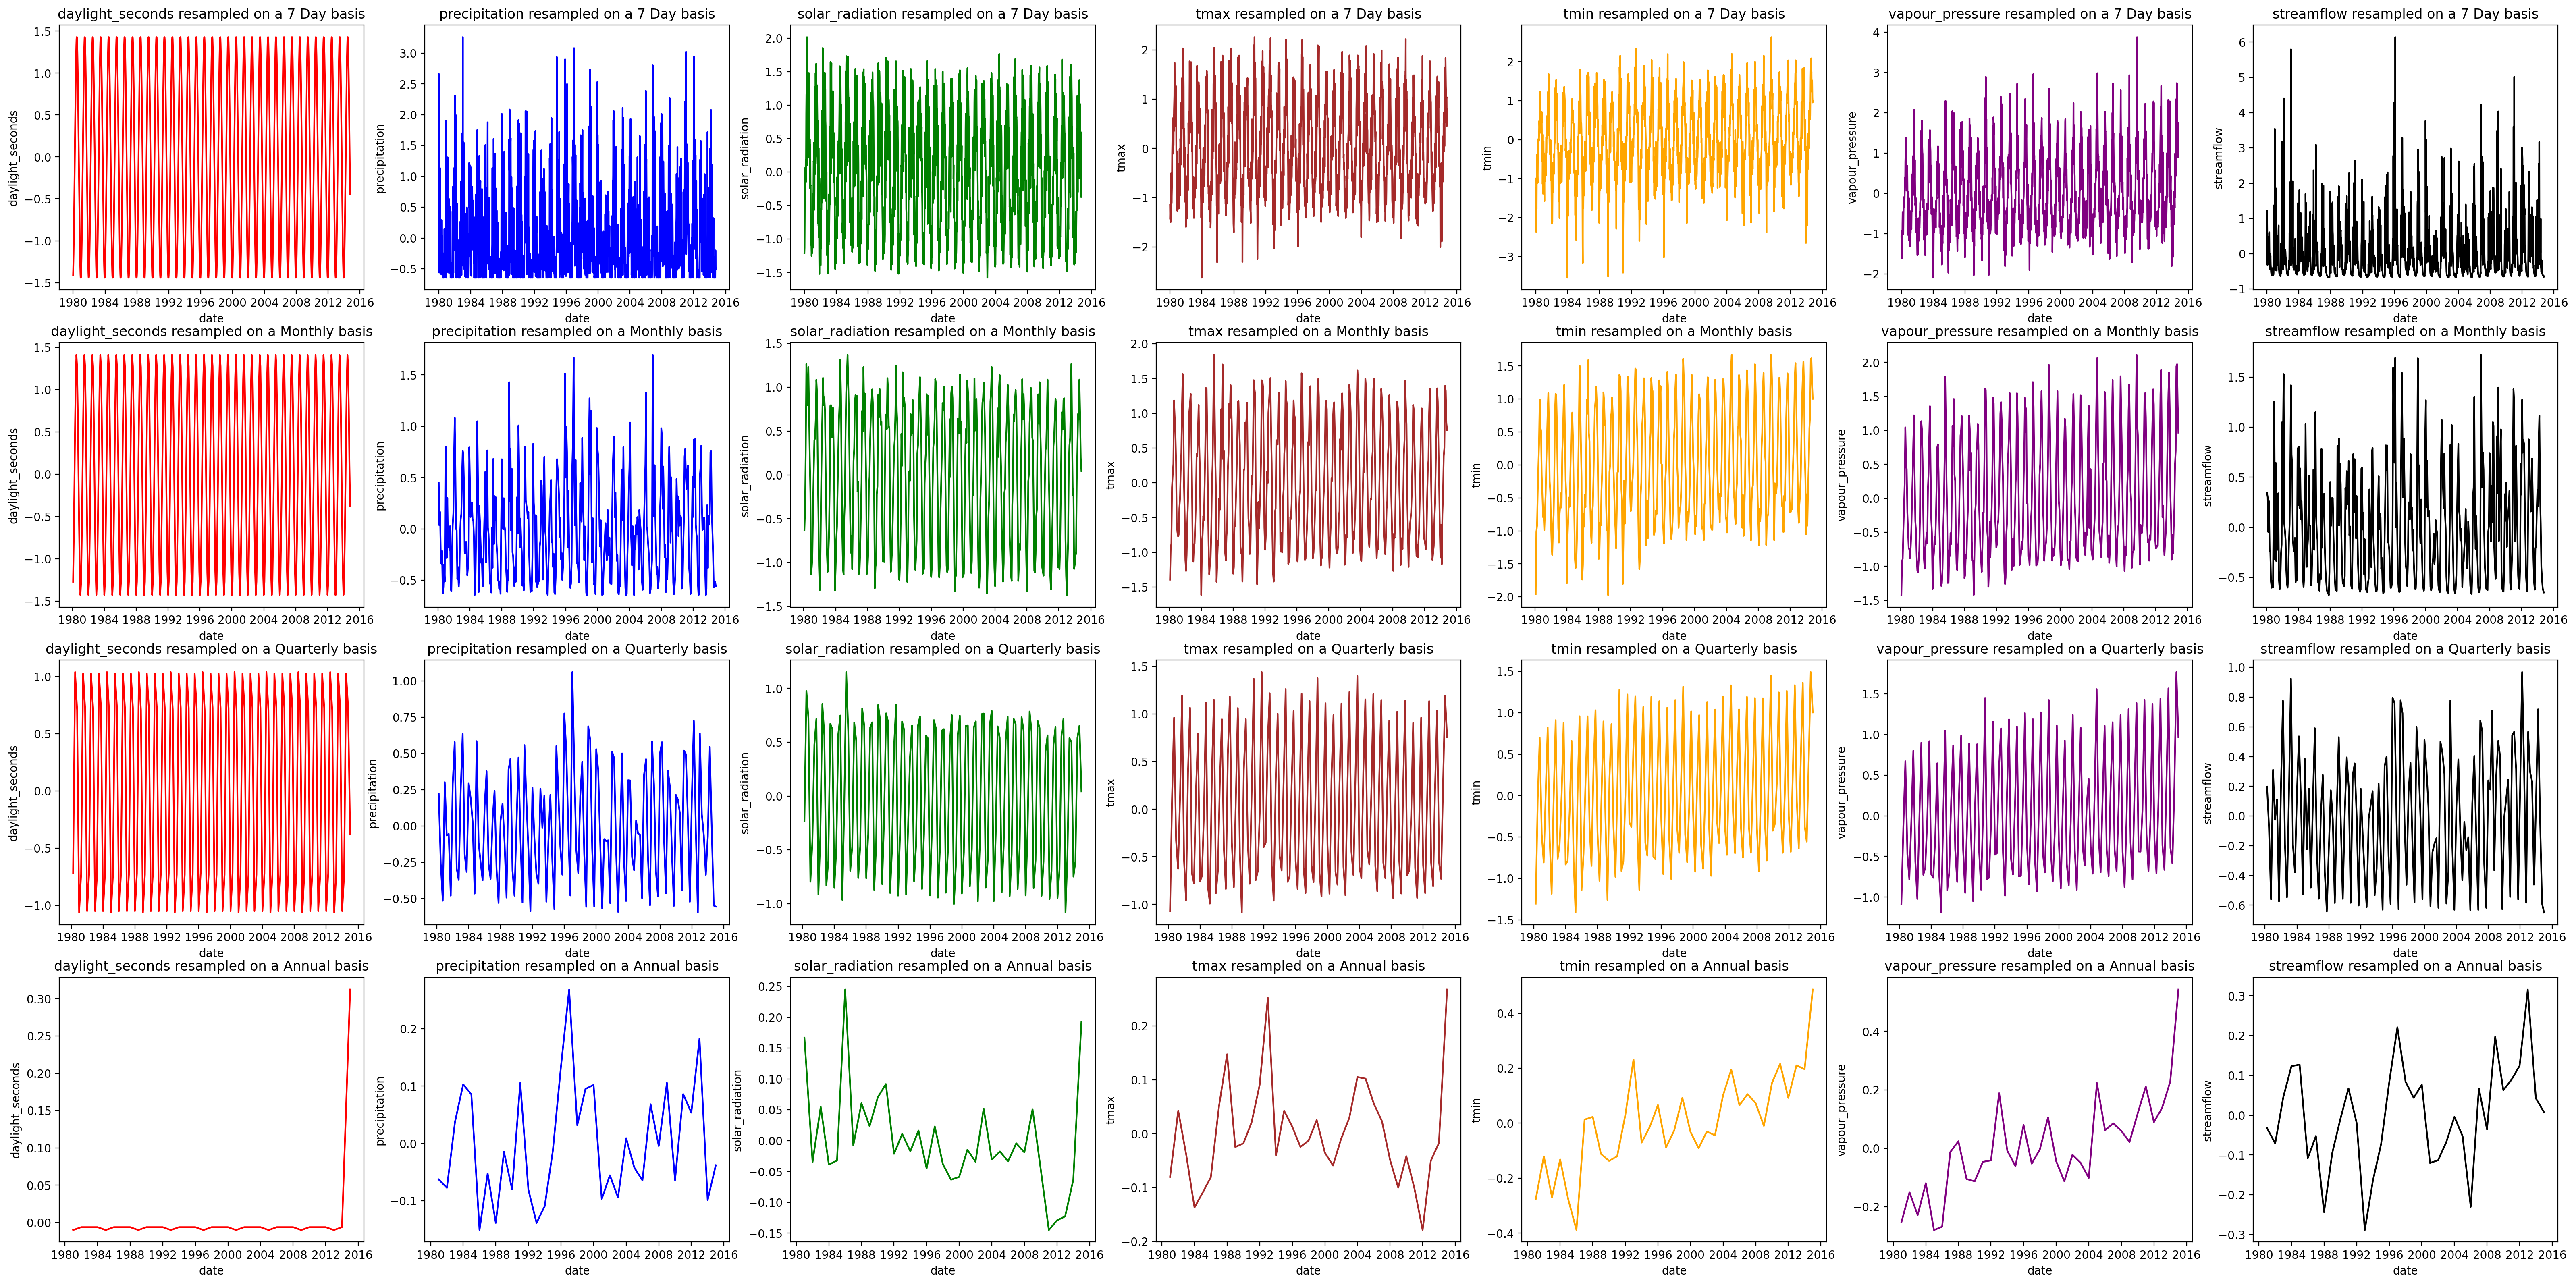

In [ ]:
# Create dateTimeIndex within df
cols=['Year', 'Mnth', 'Day']
#df_withDateTime=df_vis.copy()
df_withDateTime=df_preproc.copy()
df_withDateTime['date'] = df_scaled[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
df_withDateTime['date'] = pd.to_datetime(df_withDateTime['date'])

# Create subplots
titles = df_withDateTime.columns[1:8]
feature_keys = df_withDateTime.columns[1:8]
fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(40, 20), dpi=200, facecolor="w", edgecolor="k")
#time_period = ['7D', 'M', 'Q', 'A']
time_period = {'7D': '7 Day', 'M': 'Monthly', 'Q': 'Quarterly', 'A': 'Annual'}
colors = ['red','blue','green','brown','orange','purple','black']


y_pos=0
x_pos=0
for feature in feature_keys:
    y_pos=0
    for period in time_period:
        resampled_df = df_withDateTime.resample(period,on = 'date').mean().reset_index(drop=False)
        sns.lineplot(x=resampled_df['date'], y=resampled_df[feature],ax=axes[y_pos,x_pos],color=colors[x_pos])
        axes[y_pos,x_pos].set_title(f'{feature} resampled on a {time_period[period]} basis')
        #axes[x_pos,y_pos].set_title(str(feature), " resampled-",str(time_period))
        y_pos+=1
    x_pos+=1
plt.show()


### 4.6 Exploring Seasonal Decomposition
It is clear from previous exploration that there is some sort of seasonality for most of the features. Any series can be decomposed into a sum of 3 components: Trend, Seasonal, and Residual components. We are especially interested in analysing the first 2 Components.

Thus, we will utilise the `statsmodels` library to seasonally decompose each of our features and target data.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Create dateTimeIndex within df
cols=['Year', 'Mnth', 'Day']
df_withDateTime=df_preproc.copy()
df_withDateTime['date'] = df_scaled[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
df_withDateTime['date'] = pd.to_datetime(df_withDateTime['date'])

# Resample on a monthly basis to see a clearer visualisation.
resampled_df = df_withDateTime.resample('7D',on = 'date').mean().reset_index(drop=False)

# Set new index
resampled_df.set_index('date', inplace=True)

# Create feature_keys index
feature_keys = df_withDateTime.columns[2:8]


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### 4.6.1 Season Decomposition of `Precipitation`.

Seasonal Decomposition of  precipitation


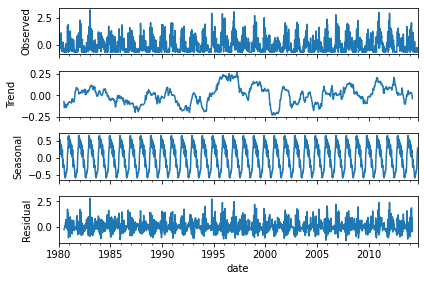

In [ ]:
print('Seasonal Decomposition of ', feature_keys[0])

analysis = resampled_df[[feature_keys[0]]].copy()

decompose_result_mult = seasonal_decompose(analysis, model="additive")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

#### 4.6.2 Season Decomposition of `solar_radiation`.

Seasonal Decomposition of  solar_radiation


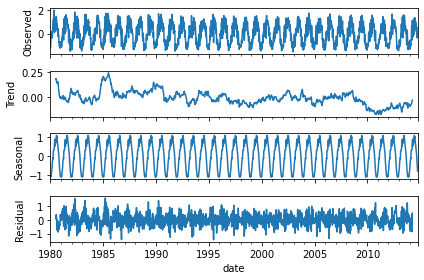

In [ ]:
print('Seasonal Decomposition of ', feature_keys[1])

analysis = resampled_df[[feature_keys[1]]].copy()

decompose_result_mult = seasonal_decompose(analysis, model="additive")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

#### 4.6.3 Season Decomposition of `tmax`.

Seasonal Decomposition of  tmax


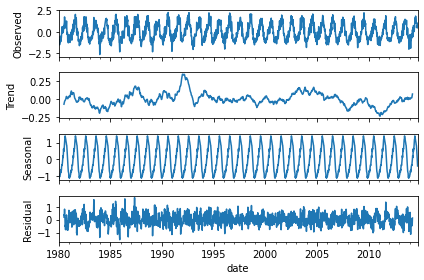

In [ ]:
print('Seasonal Decomposition of ', feature_keys[2])

analysis = resampled_df[[feature_keys[2]]].copy()

decompose_result_mult = seasonal_decompose(analysis, model="additive")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

#### 4.6.4 Season Decomposition of `tmin`.

Seasonal Decomposition of  tmin


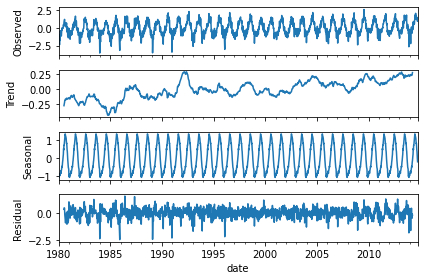

In [ ]:
print('Seasonal Decomposition of ', feature_keys[3])

analysis = resampled_df[[feature_keys[3]]].copy()

decompose_result_mult = seasonal_decompose(analysis, model="additive")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

#### 4.6.5 Season Decomposition of `vapour_pressure`.

Seasonal Decomposition of  vapour_pressure


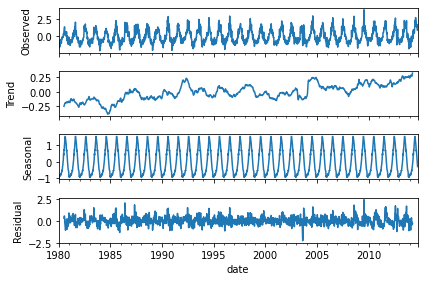

In [ ]:
print('Seasonal Decomposition of ', feature_keys[4])

analysis = resampled_df[[feature_keys[4]]].copy()

decompose_result_mult = seasonal_decompose(analysis, model="additive")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

#### 4.6.6 Season Decomposition of `streamflow`.

Seasonal Decomposition of  streamflow


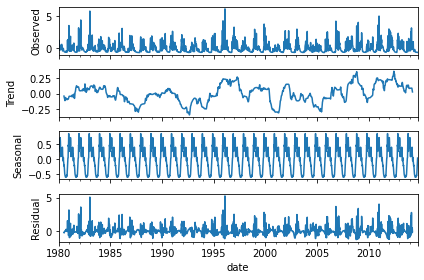

In [ ]:
print('Seasonal Decomposition of ', feature_keys[5])

analysis = resampled_df[[feature_keys[5]]].copy()

decompose_result_mult = seasonal_decompose(analysis, model="additive")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

We can tell from the above seasonal decompositions that `precipitation`, `solar_radiation`, `tmax`, and `streamflow` have no observable trend ie their mean value doesn't change over time after ignoring their seeasonal components. Only `tmin` has a slight observable increasing trend over time. These trends are not desireable when training our models later on. Hence, we need to begin to study the concept of stationarity.

# 5 Stationary data

### Stationarity
Stationarity is the property of having constant statistical properties such as mean, variance, and standard deviation. Time series models assume that data is stationary. It is hence important that we identify and seperate trends and seasonality from time series before applying any machine learning models. 

### Is our data stationary?
We already have an intuition that it is not, given that the mean values of the 4 features mentioned above are not generally constant with time. We can check stationarity in a few different ways: Plotting rolling statistics, and using statistical tests (ADF, KPSS, ACF plots)

### 5.1 Plotting rolling statistics
By plotting the rolling mean and standard deviation, we can visually check for trends and check if variances are changing. If there are changing trends or variances, we can conclude that data is likely not stationary.

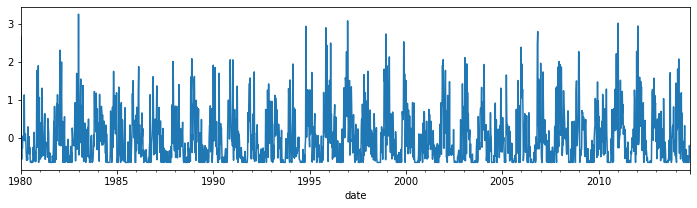

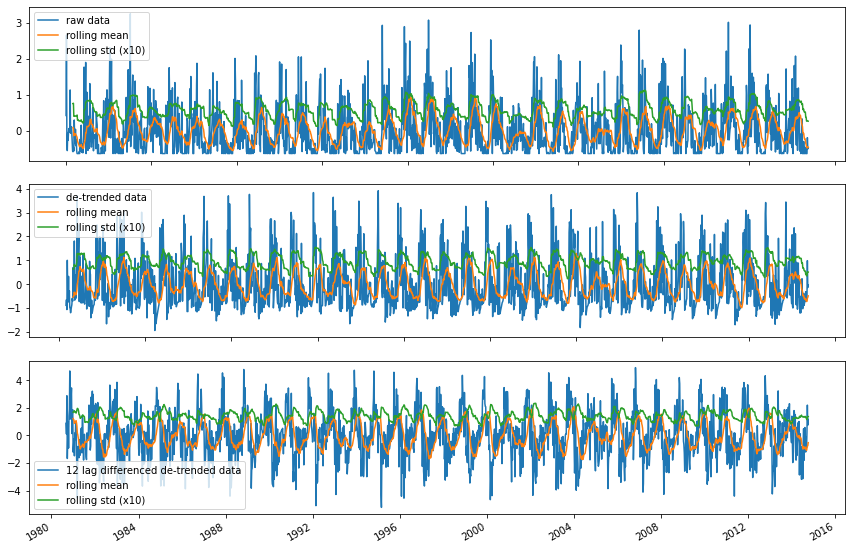

In [ ]:
import matplotlib.dates as mdates
%matplotlib inline
#plt.style.use('Solarize_Light2')
var = 'precipitation'
window_size =18

#r = requests.get('https://datamarket.com/api/v1/list.json?ds=22qx')
#jobj = json.loads(r.text[18:-1])
#data = jobj[0]['data']
df = resampled_df
train = df.iloc[:-10, :]
test = df.iloc[-10:, :]
pred = test.copy()
df[var].plot(figsize=(12,3));
#plt.title(jobj[0]['title']);

df['z_data'] = (df[var] - df[var].rolling(window=window_size).mean()) / df[var].rolling(window=window_size).std()
df['zp_data'] = df['z_data'] - df['z_data'].shift(window_size)

def plot_rolling(df):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    ax[0].plot(df.index, df[var], label='raw data')
    ax[0].plot(df[var].rolling(window=window_size).mean(), label="rolling mean");
    ax[0].plot(df[var].rolling(window=window_size).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df.index, df.z_data, label="de-trended data")
    ax[1].plot(df.z_data.rolling(window=window_size).mean(), label="rolling mean");
    ax[1].plot(df.z_data.rolling(window=window_size).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(df.index, df.zp_data, label="12 lag differenced de-trended data")
    ax[2].plot(df.zp_data.rolling(window=window_size).mean(), label="rolling mean");
    ax[2].plot(df.zp_data.rolling(window=window_size).std(), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()
    
plot_rolling(df)

### 5.2 Statistical tests to check for stationarioty

We can implement an `Augmented Dickey-Fuller Test` on the entire dataset from 1980 to 2014 to assess if our dataset is stationary. From the tests conducted, we can confirm that all of our data is stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Create dateTimeIndex within df
cols=['Year', 'Mnth', 'Day']
df_withDateTime=df_preproc.copy()
df_withDateTime['date'] = df_scaled[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
df_withDateTime['date'] = pd.to_datetime(df_withDateTime['date'])

# Resample on a monthly basis to see a clearer visualisation.
resampled_df = df_withDateTime.resample('7D',on = 'date').mean().reset_index(drop=False)

# Set new index
resampled_df.set_index('date', inplace=True)

feature_keys = resampled_df.columns[2:8]
df = resampled_df.copy()
for feature in feature_keys:
    print(" > Is the", feature, "data stationary ?")
    dftest = adfuller(df[feature], autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    print("")



 > Is the precipitation data stationary ?
Test statistic = -12.659
P-value = 0.000
Critical values :
	1%: -3.434010540924675 - The data is  stationary with 99% confidence
	5%: -2.8631569252072455 - The data is  stationary with 95% confidence
	10%: -2.5676307994135956 - The data is  stationary with 90% confidence

 > Is the solar_radiation data stationary ?
Test statistic = -15.947
P-value = 0.000
Critical values :
	1%: -3.434010540924675 - The data is  stationary with 99% confidence
	5%: -2.8631569252072455 - The data is  stationary with 95% confidence
	10%: -2.5676307994135956 - The data is  stationary with 90% confidence

 > Is the tmax data stationary ?
Test statistic = -15.598
P-value = 0.000
Critical values :
	1%: -3.434010540924675 - The data is  stationary with 99% confidence
	5%: -2.8631569252072455 - The data is  stationary with 95% confidence
	10%: -2.5676307994135956 - The data is  stationary with 90% confidence

 > Is the tmin data stationary ?
Test statistic = -14.227
P-va

### 5.3 Delayed Streamflow Variable 

Lastly, we also explore whether old `streamflow` has the ability to contribute in predicting subsequent `streamflow` data, assessing its suitability to be used as a predictor value. We do this by analysing the correlation between `streamflow` and `streamflow` delayed by 1-5 days.  

In [ ]:
df_sdelay = df_preproc[['streamflow']].copy()
df_preproc_delay = df_preproc.copy()
df_sdelay['s_+1'] = df_sdelay['streamflow'].shift(1)
df_sdelay['s_+2'] = df_sdelay['streamflow'].shift(2)
df_sdelay['s_+3'] = df_sdelay['streamflow'].shift(3)
df_sdelay['s_+4'] = df_sdelay['streamflow'].shift(4)
df_sdelay['s_+5'] = df_sdelay['streamflow'].shift(5)
df_sdelay

streamflow      s_+1      s_+2      s_+3      s_+4      s_+5
0        0.581178       NaN       NaN       NaN       NaN       NaN
1        0.272042  0.581178       NaN       NaN       NaN       NaN
2        0.165443  0.272042  0.581178       NaN       NaN       NaN
3        0.144123  0.165443  0.272042  0.581178       NaN       NaN
4        0.559858  0.144123  0.165443  0.272042  0.581178       NaN
...           ...       ...       ...       ...       ...       ...
12700   -0.666026 -0.666026 -0.655366 -0.655366 -0.655366 -0.655366
12701   -0.655366 -0.666026 -0.666026 -0.655366 -0.655366 -0.655366
12702   -0.634046 -0.655366 -0.666026 -0.666026 -0.655366 -0.655366
12703   -0.634046 -0.634046 -0.655366 -0.666026 -0.666026 -0.655366
12704   -0.655366 -0.634046 -0.634046 -0.655366 -0.666026 -0.666026

[12705 rows x 6 columns]

<Figure size 1920x1920 with 0 Axes>

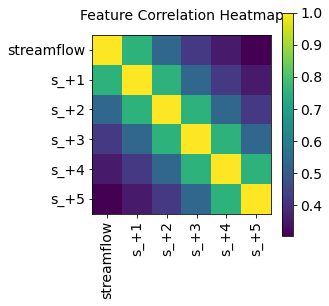

In [ ]:
figure(figsize=(24,24), dpi=80)
show_heatmap(df_sdelay)

We thus see how `streamflow` delayed by 1 and 2 days (`s_+1`,`s_+2`) are still relatively highly correlated to the `streamflow` of the present day. This indicates the presence of some memory in `streamflow`, and thus, we shall add `s_+1` and `s_+2` as predictors into our dataset to better predcit `streamflow` 

In [ ]:
df_preproc_delay['s_+1'] = df_preproc['streamflow'].shift(1)
df_preproc_delay['s_+2'] = df_preproc['streamflow'].shift(2)
df_preprocced = df_preproc_delay.dropna()
df_preprocced.head(10)




Year  daylight_seconds  precipitation  solar_radiation      tmax  \
2   1980         -1.400244       0.269130        -1.274712 -1.038476   
3   1980         -1.400244       0.836404        -1.349519 -1.117428   
4   1980         -1.400244       1.025254        -1.569853 -1.215520   
5   1980         -1.400244      -0.643883        -0.658862 -1.414096   
6   1980         -1.399869      -0.643883        -0.591592 -1.416488   
7   1980         -1.360410       3.216632        -1.110518 -1.774165   
8   1980         -1.360410       3.175230        -1.829633 -2.555311   
9   1980         -1.360410       1.968774        -1.262315 -1.788520   
10  1980         -1.360035       1.993469        -1.006480 -1.691624   
11  1980         -1.320577       3.060468        -0.532775 -0.610221   

        tmin  vapour_pressure  streamflow  dayOfYear_sin  dayOfYear_cos  \
2  -1.108819        -1.042006    0.165443       0.067547       1.423668   
3  -1.068755        -1.015361    0.144123       0.091746       1.422208   
4  -0.818830        -0.834587    0.559858       0.115916       1.420331   
5  -2.322195        -1.698330    0.048185       0.140051       1.418039   
6  -2.497715        -1.781136   -0.111713       0.164142       1.415331   
7  -2.308840        -1.693358   -0.186332       0.188184       1.412209   
8  -2.203910        -1.656629   -0.196992       0.212169       1.408674   
9  -1.978787        -1.562023   -0.282271       0.236090       1.404726   
10 -2.169569        -1.641153   -0.228972       0.259940       1.400367   
11 -1.684982        -1.385521    2.606551       0.283712       1.395598   

        s_+1      s_+2  
2   0.272042  0.581178  
3   0.165443  0.272042  
4   0.144123  0.165443  
5   0.559858  0.144123  
6   0.048185  0.559858  
7  -0.111713  0.048185  
8  -0.186332 -0.111713  
9  -0.196992 -0.186332  
10 -0.282271 -0.196992  
11 -0.228972 -0.282271

# 6 Machine Learning Models
### Introduction
We will begin evaluating classical time series models. We will then progress into more complex neural networks such as LSTMs and compare performance at the end. 

### Defining model performance
For our models, we will use RMSE to compare their performance, because it penalises outliers more heavily, thus rewarding models that can better minimise such huge errors, something we want to achieve when predicting streamflow.

### Choosing ML Models
We have chosen 2 classic models: `SARIMAX` and `XGBoost`, as well as 2 deep learning models: `LSTM` implemented with Keras Library and Facebook's `Prophet`. The advantage of the classical models over the deep learning models is that they offer high interpretability and are easy to implement. Downsides include the fact that they require stationary data to learn properly. On the other hand, deep learning models are able to handle complex non-linear patterns and require fewer assumptions to use, including not requiring stationary data. Deep learning models however offer lower interpretability (’black boxes’) and requires more data, not to mention requiring longer periods of time to train. 

### 6.1 SARIMAX
SARIMAX stands for Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors. In short, SARIMAX models are composed of 3 parts: Autoregressive (AR), Moving-Average (MA), and Integrated (I). They also offer the benefit of being able to deal with seasonality, which is vital for our dataset. Furthermore, SARIMAX can also take in Exogenous (X) data, hence making it suitable for our multivariate time series problem.

#### 6.1.1 Data Preprocessing for SARIMAX 
Creating a `dateTimeIndex` within the dataframe and shifting the target variable to the last column

In [ ]:
# from sklearn.model_selection import TimeSeriesSplit
# tscv = TimeSeriesSplit(n_splits=5)
# X = df_preproc.drop(columns=['precipitation']).to_numpy()
# y=df_preproc['precipitation'].to_numpy()
# for train_index, test_index in tscv.split(X):
#     #print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
    
#     print(X_train.shape)
    


In [ ]:
# Create dateTimeIndex within df
cols=['Year', 'Mnth', 'Day']
df_withDateTime=df_preproc.copy()
df_withDateTime['date'] = df_scaled[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
df_withDateTime['date'] = pd.to_datetime(df_withDateTime['date'])
df_withDateTime.set_index('date', inplace=True)

# Move target column
column_to_move = df_withDateTime.pop("streamflow")
df_withDateTime.insert(9, "streamflow", column_to_move)
df_withDateTime = df_withDateTime.dropna()

df_withDateTime.head()

Year  daylight_seconds  precipitation  solar_radiation      tmax  \
date                                                                           
1980-01-01  1980         -1.440077       1.329592        -1.566542 -0.924833   
1980-01-02  1980         -1.412006       0.762317        -1.454403 -0.902104   
1980-01-03  1980         -1.400244       0.269130        -1.274712 -1.038476   
1980-01-04  1980         -1.400244       0.836404        -1.349519 -1.117428   
1980-01-05  1980         -1.400244       1.025254        -1.569853 -1.215520   

                tmin  vapour_pressure  dayOfYear_sin  dayOfYear_cos  \
date                                                                  
1980-01-01 -0.391477        -0.496114       0.019092       1.425337   
1980-01-02 -0.557458        -0.628884       0.043326       1.424711   
1980-01-03 -1.108819        -1.042006       0.067547       1.423668   
1980-01-04 -1.068755        -1.015361       0.091746       1.422208   
1980-01-05 -0.818830        -0.834587       0.115916       1.420331   

            streamflow  
date                    
1980-01-01    0.581178  
1980-01-02    0.272042  
1980-01-03    0.165443  
1980-01-04    0.144123  
1980-01-05    0.559858

#### 6.1.2 Finding the best paramters for SARIMAX
SARIMAX models offer 2 main hyperparamters: `Order` (p,d,q) and `Seasonal Order` (P,D,Q,S), where *p*= non-seasonal autoregressive (AR) order, *d* = non-seasonal differencing, *q* = non-seasonal moving average (MA) order, *P* = seasonal AR order, *D* = seasonal differencing, *Q* = seasonal MA order, and *S* = length of repeating seasonal pattern. We must search through all possible combinations of hyperparameters to learn which results in the best model performance. 

For efficiency’s sake, we have skipped this cell since it takes a considerable amount of time to run. Should you wish to run it, change `False` to `True`. We have determined that the best combination is (1,1,1), (1,0,0,365).

In [ ]:
import warnings
import statsmodels.api as sm

if False: # Change this to True if you want to run this code
    warnings.filterwarnings("ignore")
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            print('trying new combi')
            mod = sm.tsa.statespace.SARIMAX(endog=df_withDateTime['streamflow'],\
                                            trend='n',\
                                            order=param,\
                                            seasonal_order=param_seasonal,\
                                            exog = df_withDateTime.iloc[:,0:-1])

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))


#### 6.1.3 Train Test Split and Resampling
Unfortunately, SARIMAX is too slow when the seasonal order increases to 365 (daily data). Hence, we have to resample our data set to a weekly basis.

In [ ]:
# # Create dateTimeIndex within df
# cols=['Year', 'Mnth', 'Day']
# #df_withDateTime=df_vis.copy()
# df_withDateTime=df_preproc.copy()
# df_withDateTime['date'] = df_scaled[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
# df_withDateTime['date'] = pd.to_datetime(df_withDateTime['date'])
# #df_withDateTime = df_withDateTime.resample('M',on = 'date').mean().reset_index(drop=False)
# df_withDateTime.set_index('date', inplace=True)
# column_to_move = df_withDateTime.pop("streamflow")
# df_withDateTime.insert(9, "streamflow", column_to_move)
# df_withDateTime = df_withDateTime.dropna()
#df_withDateTime = df_withDateTime.drop(columns=['s_+1','s_+2'])

X_train = df_withDateTime.iloc[:,:-1][:'2014-01-31']
y_train = df_withDateTime.iloc[:,-1][:'2014-01-31']
X_test = df_withDateTime.iloc[:,:-1]['2014-02-01':]
y_test = df_withDateTime.iloc[:,-1]['2014-02-01':]
y = df_withDateTime['streamflow']
train_size = len(X_train)
test_size = len(X_test)

# Resampling by week
X_train_7D = X_train.resample('W').mean()
y_train_7D =y_train.resample('W').mean()
X_test_7D = X_test.resample('W').mean()
y_test_7D = y_test.resample('W').mean()

X_train_7D = X_train_7D.iloc[:-1]
y_train_7D = y_train_7D.iloc[:-1]



#### 6.1.4 Fitting the model

/Users/JulianYap/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


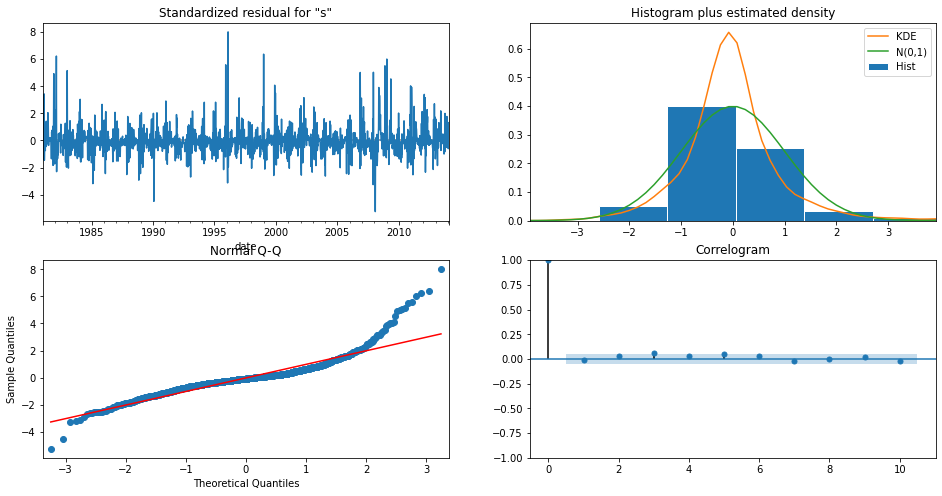

In [ ]:

mod = sm.tsa.statespace.SARIMAX(endog=y_train_7D,
                                order=(1, 1, 1),
                                seasonal_order=(1, 0, 0, 52),
                                exog = X_train_7D,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
results.plot_diagnostics(figsize=(16, 8))
plt.show()

#### 6.1.5 Forecasting `streamflow` with `SARIMAX`

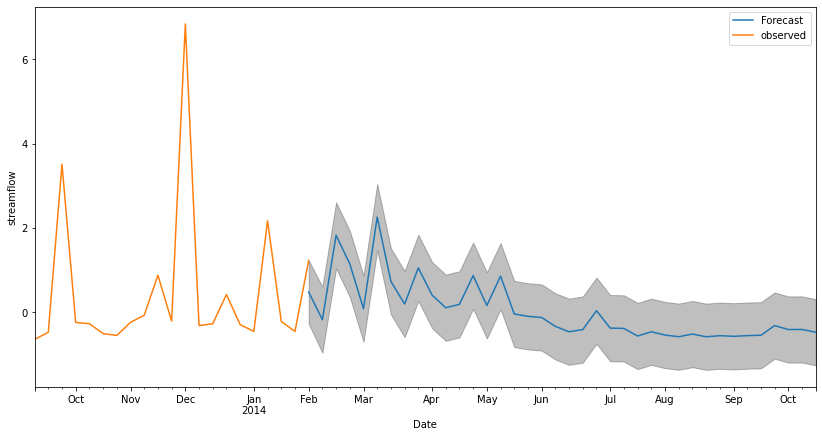

In [ ]:
predictions= results.get_forecast(steps =len(X_test_7D),exog=X_test_7D)
pred_ci = predictions.conf_int()
predictions.predicted_mean.plot(label='Forecast')
ax = y[-400:-(300-len(X_test_7D)-5)].plot(label='observed', figsize=(14, 7))
#predictions.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('streamflow')
plt.legend()
plt.show()



#### 6.1.6 Model Error

In [ ]:
from statsmodels.tools.eval_measures import rmse

predictions=predictions.predicted_mean
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.rename(columns={0:'predicted_mean'}, inplace=True)
# predictions['Actual'] = y_test
error_sarimax= rmse(predictions['predicted_mean'], y_test_7D)
print("Model error for SARIMAX is ", str(error_sarimax))

NameError: ignored

### 6.2 XGBoost
XGBoost is a type of decision tree designed for speed and performance and stands for Extreme Gradient Boosting. We chose this model because  it performs the best when comparing amongst other gradient boosted and decision tree methods, and is highly popular in data science competitions. Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

#### 6.2.1 Fitting the Model
We have set the `early_stopping_rounds` to 20. This will  prevent the model from training more than 20 rounds after the validation loss starts to increase. 

In [ ]:
import xgboost as xgb
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=20,
       verbose=True,eval_metric=["rmse", "logloss"]) # Change verbose to True if you want to see it train

[12:38:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.04672	validation_0-logloss:0.062821	validation_1-rmse:1.04016	validation_1-logloss:0.343049
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.985463	validation_0-logloss:-1.38172	validation_1-rmse:0.978211	validation_1-logloss:-0.320151
[2]	validation_0-rmse:0.93239	validation_0-logloss:-1.58538	validation_1-rmse:0.917694	validation_1-logloss:-0.647235
[3]	validation_0-rmse:0.885217	validation_0-logloss:-2.44929	validation_1-rmse:0.858396	validation_1-logloss:-3.32336
[4]	validation_0-rmse:0.843612	validation_0-logloss:-2.91815	validation_1-rmse:0.806866	validation_1-logloss:-4.02782
[5]	validation_0-rmse:0.808328	validation_0-logloss:-3.25069	validation_1-rmse:0.772157	validation_1-logloss:-4.41166
[6]	validati

XGBRegressor(n_estimators=1000)

#### 6.2.2 Forecasting `streamflow` with `XGBoost`

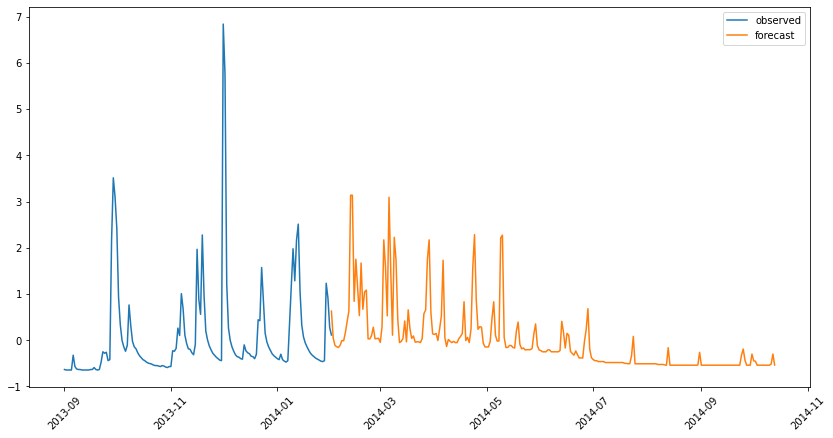

In [ ]:
xgbdf = pd.DataFrame()
xgbdf['forecast']=reg.predict(X_test,ntree_limit=reg.best_ntree_limit)
xgbdf['date'] = X_test.index
xgbdf['date'] = pd.to_datetime(xgbdf['date'])
#df_withDateTime = df_withDateTime.resample('M',on = 'date').mean().reset_index(drop=False)
xgbdf.set_index('date', inplace=True)
xgbdf['observed']=df_withDateTime['streamflow']
plt.figure(figsize=(14, 7))
plt.plot(df_withDateTime['streamflow']["2013-09-01":'2014-02-01'],label ='observed')
plt.plot(xgbdf['forecast'],label='forecast')
plt.xticks(rotation=45)
plt.legend()
plt.show()

#### 6.2.3 Model Error

In [ ]:
error_xgboost = rmse(xgbdf['observed'], xgbdf['forecast'])
print("Model error for XGBoost is", str(error_xgboost))

Model error for XGBoost is 0.47910729615658837


#### 6.2.4 Training Curves

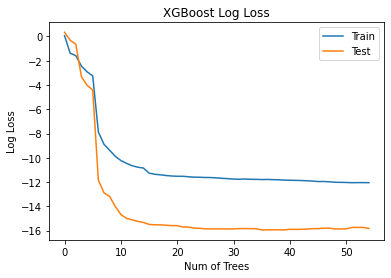

In [ ]:
# Plotting loss curves
results = reg.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.xlabel('Num of Trees')

plt.title('XGBoost Log Loss')
plt.show()


We can see that the XGBoost model performs well on the test set, even outperforming the train data. Compared to SARIMAX, which is too slow for daily data, XGBoost can train very quickly on daily data, but at the cost of a greater RMSE of 0.479 vs 0.25 for SARIMAX.

#### 6.2.5 Feature Importance
As expected, precipitation has the highest feature importance.

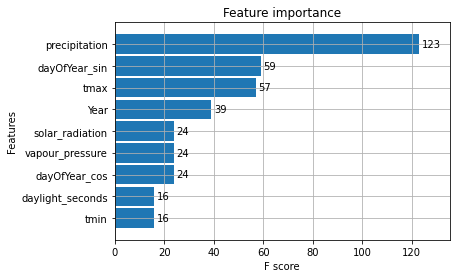

In [ ]:
from xgboost import plot_importance, plot_tree

_ = plot_importance(reg, height=0.9)


### 6.3 Long Short-Term Memory (LSTM) Model 
LSTM Models, unlike conventional feedforward neural networks, have feedback connections. They are hence well-suited to processing and making predictions on time series data since there can be lags of unknown duration in time series data. In other words, LSTM networks (or RNNs in general) solve the problem that traditional neural networks suffer from: they are networks with loops in them, allowing learned information to persist in the long term. 

#### 6.3.1 Formatting data and Train Test Split

In [ ]:
# Create dateTimeIndex within df
cols=['Year', 'Mnth', 'Day']
df_withDateTime=df_preproc.copy()
df_withDateTime['date'] = df_scaled[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
df_withDateTime['date'] = pd.to_datetime(df_withDateTime['date'])
df_withDateTime.set_index('date', inplace=True)
column_to_move = df_withDateTime.pop("streamflow")
df_withDateTime.insert(9, "streamflow", column_to_move)
df_withDateTime = df_withDateTime.dropna()
df_withDateTime.reset_index(inplace=True)
df_withDateTime.drop(columns=['dayOfYear_sin','dayOfYear_cos'],inplace=True)

train_size = int(0.95 * len(df_withDateTime))
test_size = len(df_withDateTime) - train_size
X_train_old, y_train_old = pd.DataFrame(df_withDateTime.iloc[:train_size,:-1]), pd.DataFrame(df_withDateTime.iloc[:train_size, -1])
X_test_old, y_test_old = pd.DataFrame(df_withDateTime.iloc[train_size:,:-1]), pd.DataFrame(df_withDateTime.iloc[train_size:, -1])
X_train_old=X_train_old.drop(columns=['date'])
X_test_old=X_test_old.drop(columns=['date'])
X_test_olddf=X_test_old.copy()
y_test_olddf=y_test_old.copy()
X_train_olddf=X_train_old.copy()
y_train_olddf=y_train_old.copy()
X_train_old14=X_train_old[-14:]
y_train_old14=y_train_old[-14:]

X_train_old, y_train_old = np.array(X_train_old),np.array(y_train_old)


#### 6.3.2  Augmenting data 

In [ ]:
hops=14
X_train=[]
y_train=[]
for i in range(hops,train_size):
    X_train.append(X_train_old[i-14:i])
    y_train.append(y_train_old[i][0])
X_train,y_train=np.array(X_train),np.array(y_train)


X_train_reshaped=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],X_train.shape[2]))
X_train_reshaped.shape


(12055, 14, 7)

#### 6.3.3 Importing libraries and defining R-Squared

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import optimizers 
from tensorflow.keras.optimizers import RMSprop
from keras import metrics
from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#### 6.3.4 Building the Neural Network
We used the RMSprop optimizer with the MSE as the loss function. Experiemnt metrics chosen was the R-Squared function.

In [ ]:
model = Sequential()
model.add(LSTM(units=256,return_sequences=True,input_shape=(14,7)))
model.add(Dropout(0.2))
model.add(LSTM(units=128))
model.add(Dropout(0.2))
model.add(Dense(1))
opt = keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss ='mean_squared_error',metrics=[coeff_determination])

#### 6.3.5 Fitting the Model

In [ ]:
history = model.fit(X_train_reshaped, y_train,epochs=100,batch_size=64,validation_split=0.2)

Epoch 1/100
151/151 [==============================] - 7s 46ms/step - loss: 0.6283 - coeff_determination: 0.3032 - val_loss: 1.0552 - val_coeff_determination: -9.4139
Epoch 2/100
151/151 [==============================] - 11s 72ms/step - loss: 0.6138 - coeff_determination: 0.3012 - val_loss: 0.9494 - val_coeff_determination: -16.0262
Epoch 3/100
151/151 [==============================] - 8s 54ms/step - loss: 0.5899 - coeff_determination: 0.2896 - val_loss: 0.9181 - val_coeff_determination: -8.4838
Epoch 4/100
151/151 [==============================] - 8s 56ms/step - loss: 0.5820 - coeff_determination: 0.3584 - val_loss: 0.8921 - val_coeff_determination: -31.7039
Epoch 5/100
151/151 [==============================] - 9s 60ms/step - loss: 0.5583 - coeff_determination: 0.3390 - val_loss: 0.7848 - val_coeff_determination: -7.5522
Epoch 6/100
151/151 [==============================] - 9s 57ms/step - loss: 0.5415 - coeff_determination: 0.3788 - val_loss: 0.7495 - val_coeff_determination: -3.

Epoch 50/100
151/151 [==============================] - 8s 52ms/step - loss: 0.4378 - coeff_determination: 0.5022 - val_loss: 0.6925 - val_coeff_determination: -12.1903
Epoch 51/100
151/151 [==============================] - 7s 50ms/step - loss: 0.4321 - coeff_determination: 0.5034 - val_loss: 0.7443 - val_coeff_determination: -5.6804
Epoch 52/100
151/151 [==============================] - 8s 52ms/step - loss: 0.4371 - coeff_determination: 0.4812 - val_loss: 0.7731 - val_coeff_determination: -3.6994
Epoch 53/100
151/151 [==============================] - 8s 52ms/step - loss: 0.4228 - coeff_determination: 0.5044 - val_loss: 0.6115 - val_coeff_determination: -9.5060
Epoch 54/100
151/151 [==============================] - 8s 52ms/step - loss: 0.4311 - coeff_determination: 0.5043 - val_loss: 0.6956 - val_coeff_determination: -1.3472
Epoch 55/100
151/151 [==============================] - 8s 53ms/step - loss: 0.4226 - coeff_determination: 0.4966 - val_loss: 1.0284 - val_coeff_determination:

Epoch 99/100
151/151 [==============================] - 8s 53ms/step - loss: 0.4094 - coeff_determination: 0.5526 - val_loss: 0.6505 - val_coeff_determination: -0.6741
Epoch 100/100
151/151 [==============================] - 9s 59ms/step - loss: 0.4179 - coeff_determination: 0.4969 - val_loss: 0.6335 - val_coeff_determination: -0.2393


#### 6.3.5 Training curves

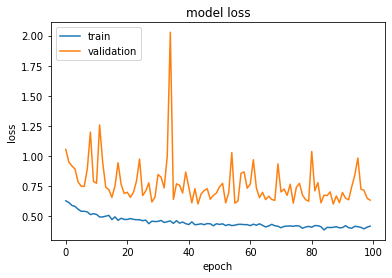

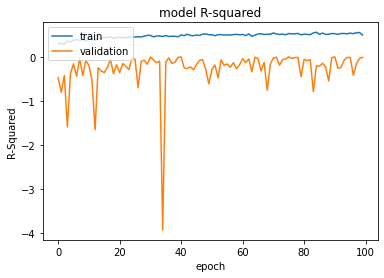

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# # summarize history for R-squared
myList=history.history['val_coeff_determination']
newList = [x / 20 for x in myList]
plt.plot(history.history['coeff_determination'])
plt.plot(newList)
plt.title('model R-squared')
plt.ylabel('R-Squared')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

We can see that training loss decreases steadily while validation loss on the validation set is erratic. This shows that our model may not be generalising well to unseen data. This is further proven by the negative R-squared value on validation data.

#### 6.3.6 Augmenting data for test data

In [ ]:
X_test_full = pd.concat((X_train_old14,X_test_olddf),axis=0)
y_test_full = pd.concat((y_train_old14,y_test_olddf),axis=0)
y_test_full=np.array(y_test_full)
print(y_test_full.shape)

(650, 1)


In [ ]:
hops=14
test_full_size=len(X_test_full)
X_test_final=[]
y_test_final=[]
for i in range(hops,test_full_size):
    X_test_final.append(X_test_full[i-14:i])
    y_test_final.append(y_test_full[i][0])
X_test_final,y_test_final=np.array(X_test_final),np.array(y_test_final)
print(X_test_final.shape,y_test_final.shape)

(636, 14, 7) (636,)


#### 6.3.7 Forecasting `streamflow` with LSTM

In [ ]:
y_pred=model.predict(X_test_final)
y_pred_df=pd.DataFrame(y_pred,columns=['streamflow_pred'])
y_test_final=pd.DataFrame(y_test_final,columns=['streamflow_actual'])
#y_pred_df.rename(columns={0:"streamflow_pred"},inplace=True)
y_pred_df
final_df = pd.concat([y_pred_df,y_test_final],axis=1)


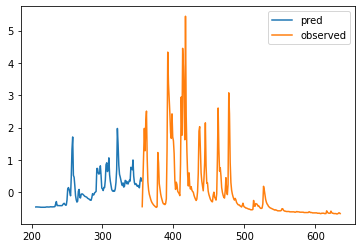

In [ ]:
plt.plot(final_df['streamflow_pred'][-430:-280],label='pred')
plt.plot(final_df['streamflow_actual'][-280:],label='observed')
plt.legend()
plt.show()

#### 6.3.8 Model Error

In [ ]:
from statsmodels.tools.eval_measures import rmse

error_lstm= rmse(final_df['streamflow_pred'], final_df['streamflow_actual'])
print("Model error for LSTM is", str(error_lstm))

Model error for LSTM is 0.7379701666745645


### 6.4 Facebook Prophet Model 
Prophet is a model developed by the Facebook Data Science team for forecasting time series data. It is based on an additive model which fits non-linear trends with yearly, weekly, and daily seasonality, including holiday effects. Considering our hydrological data possesses strong seasonal effects as observed in the EDA above, it is proposed that the Prophet Model which works best with time series with strong seasonal effects will be suitable for predicting streamflow data. 

#### 6.4.1 Formatting data and Train Test Split
Prophet requires date to be labelled as `ds` and the values to be predicted as 
`y`.

In [ ]:
df_propprep = df_withDateTime.copy()
df_propprep.reset_index(drop=True, inplace=True)
df_propprep.head()

Year  daylight_seconds  precipitation  solar_radiation      tmax      tmin  \
0  1980         -1.440077       1.329592        -1.566542 -0.924833 -0.391477   
1  1980         -1.412006       0.762317        -1.454403 -0.902104 -0.557458   
2  1980         -1.400244       0.269130        -1.274712 -1.038476 -1.108819   
3  1980         -1.400244       0.836404        -1.349519 -1.117428 -1.068755   
4  1980         -1.400244       1.025254        -1.569853 -1.215520 -0.818830   

   vapour_pressure  streamflow  dayOfYear_sin  dayOfYear_cos       date  
0        -0.496114    0.581178       0.019092       1.425337 1980-01-01  
1        -0.628884    0.272042       0.043326       1.424711 1980-01-02  
2        -1.042006    0.165443       0.067547       1.423668 1980-01-03  
3        -1.015361    0.144123       0.091746       1.422208 1980-01-04  
4        -0.834587    0.559858       0.115916       1.420331 1980-01-05

In [ ]:
df_prophet=df_propprep.rename({'date':'ds','streamflow':'y'},axis='columns')
df_prophet

Year  daylight_seconds  precipitation  solar_radiation      tmax  \
0      1980         -1.440077       1.329592        -1.566542 -0.924833   
1      1980         -1.412006       0.762317        -1.454403 -0.902104   
2      1980         -1.400244       0.269130        -1.274712 -1.038476   
3      1980         -1.400244       0.836404        -1.349519 -1.117428   
4      1980         -1.400244       1.025254        -1.569853 -1.215520   
...     ...               ...            ...              ...       ...   
12700  2014         -0.404411      -0.643883         0.268682  0.980780   
12701  2014         -0.444243      -0.643883         0.076735  0.703252   
12702  2014         -0.484076      -0.643883        -0.853133  0.083599   
12703  2014         -0.484076       0.394061        -1.200399 -0.144883   
12704  2014         -0.523908      -0.537837        -0.016456  0.606356   

           tmin  vapour_pressure         y  dayOfYear_sin  dayOfYear_cos  \
0     -0.391477        -0.496114  0.581178       0.019092       1.425337   
1     -0.557458        -0.628884  0.272042       0.043326       1.424711   
2     -1.108819        -1.042006  0.165443       0.067547       1.423668   
3     -1.068755        -1.015361  0.144123       0.091746       1.422208   
4     -0.818830        -0.834587  0.559858       0.115916       1.420331   
...         ...              ...       ...            ...            ...   
12700  1.054653         1.013273 -0.666026      -1.405629       0.191056   
12701  0.942092         0.877281 -0.655366      -1.402311       0.215141   
12702  0.963078         0.969681 -0.634046      -1.398580       0.239166   
12703  0.688351         0.634534 -0.634046      -1.394438       0.263123   
12704  0.682627         0.593149 -0.655366      -1.389888       0.287005   

              ds  
0     1980-01-01  
1     1980-01-02  
2     1980-01-03  
3     1980-01-04  
4     1980-01-05  
...          ...  
12700 2014-10-09  
12701 2014-10-10  
12702 2014-10-11  
12703 2014-10-12  
12704 2014-10-13  

[12705 rows x 11 columns]

In [ ]:
X_trainP = df_prophet.iloc[:-255]
X_testP = df_prophet[-255:]
X_testPP = X_testP.copy()
X_testPP.reset_index(drop=True, inplace=True)
X_testPP.dtypes

Year                         int64
daylight_seconds           float64
precipitation              float64
solar_radiation            float64
tmax                       float64
tmin                       float64
vapour_pressure            float64
y                          float64
dayOfYear_sin              float64
dayOfYear_cos              float64
ds                  datetime64[ns]
dtype: object

#### 6.4.2 Installing Dependencies and Fitting Model for Prophet
Prophet's multivariate modelling is done by adding regressor functions for each additional variable.

In [ ]:
!pip install pystan==2.19.1.1
!pip install prophet

     |████████████████████████████████| 65 kB 3.9 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 45 kB 2.8 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640147 sha256=1f3e004bca3c8556f5ee4734493e88f243fc426b2a699dca464565b05551ba1f
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [ ]:
from prophet import Prophet
m = Prophet()
m.add_regressor('Year')
m.add_regressor('daylight_seconds')
m.add_regressor('precipitation')
m.add_regressor('solar_radiation')
m.add_regressor('tmax')
m.add_regressor('tmin')
m.add_regressor('vapour_pressure')
m.add_regressor('dayOfYear_sin')
m.add_regressor('dayOfYear_cos')
m.fit(X_trainP)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


####6.4.3 Forecasting `streamflow` with XGBoost


In [ ]:
forecast1 = m.predict(X_testPP.drop('y', axis=1))
forecast = forecast1[['ds','yhat']]
forecast.head()

ds      yhat
0 2014-02-01  0.831448
1 2014-02-02  0.051714
2 2014-02-03 -0.279996
3 2014-02-04 -0.520340
4 2014-02-05 -0.811190

In [ ]:
final_prophet = pd.concat((X_testPP, forecast['yhat']), axis=1)
final_prophet

Year  daylight_seconds  precipitation  solar_radiation      tmax  \
0    2014         -1.041743       1.033970        -1.130946 -0.975075   
1    2014         -1.041743       0.059217        -1.191101 -1.186810   
2    2014         -1.001910      -0.231320        -1.127494 -1.403330   
3    2014         -1.001910      -0.440507        -0.702534 -1.896181   
4    2014         -0.962077      -0.643883        -0.681332 -2.475163   
..    ...               ...            ...              ...       ...   
250  2014         -0.404411      -0.643883         0.268682  0.980780   
251  2014         -0.444243      -0.643883         0.076735  0.703252   
252  2014         -0.484076      -0.643883        -0.853133  0.083599   
253  2014         -0.484076       0.394061        -1.200399 -0.144883   
254  2014         -0.523908      -0.537837        -0.016456  0.606356   

         tmin  vapour_pressure         y  dayOfYear_sin  dayOfYear_cos  \
0   -0.725347        -0.757418  0.112144       0.732189       1.217151   
1   -0.948562        -0.919039 -0.047754       0.752755       1.204278   
2   -1.360652        -1.184545 -0.154353       0.773098       1.191053   
3   -2.324103        -1.689051 -0.239631       0.793212       1.177479   
4   -3.064339        -1.975495 -0.314251       0.813090       1.163562   
..        ...              ...       ...            ...            ...   
250  1.054653         1.013273 -0.666026      -1.405629       0.191056   
251  0.942092         0.877281 -0.655366      -1.402311       0.215141   
252  0.963078         0.969681 -0.634046      -1.398580       0.239166   
253  0.688351         0.634534 -0.634046      -1.394438       0.263123   
254  0.682627         0.593149 -0.655366      -1.389888       0.287005   

            ds      yhat  
0   2014-02-01  0.831448  
1   2014-02-02  0.051714  
2   2014-02-03 -0.279996  
3   2014-02-04 -0.520340  
4   2014-02-05 -0.811190  
..         ...       ...  
250 2014-10-09 -0.394509  
251 2014-10-10 -0.414289  
252 2014-10-11 -0.630422  
253 2014-10-12 -0.044030  
254 2014-10-13 -0.452126  

[255 rows x 12 columns]

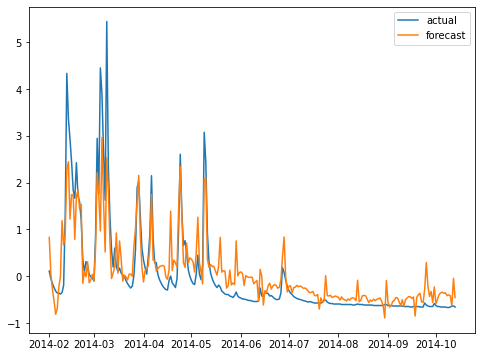

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(final_prophet['ds'],final_prophet['y'],label='actual')
plt.plot(final_prophet['ds'],final_prophet['yhat'],label='forecast')
plt.legend()

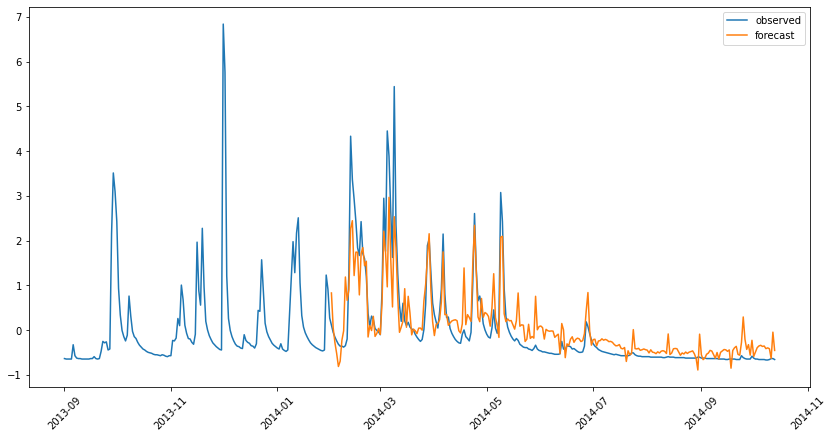

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df_prophet['ds'][12297:], df_prophet['y'][12297:],label ='observed')
# X_trainP.loc[X_trainP['ds'] == "2013-09-01"] #12297
plt.plot(final_prophet['ds'], final_prophet['yhat'],label='forecast')
plt.xticks(rotation=45)
plt.legend()
plt.show()

####6.4.4 Seasonality Trends of Streamflow extracted from Prophet

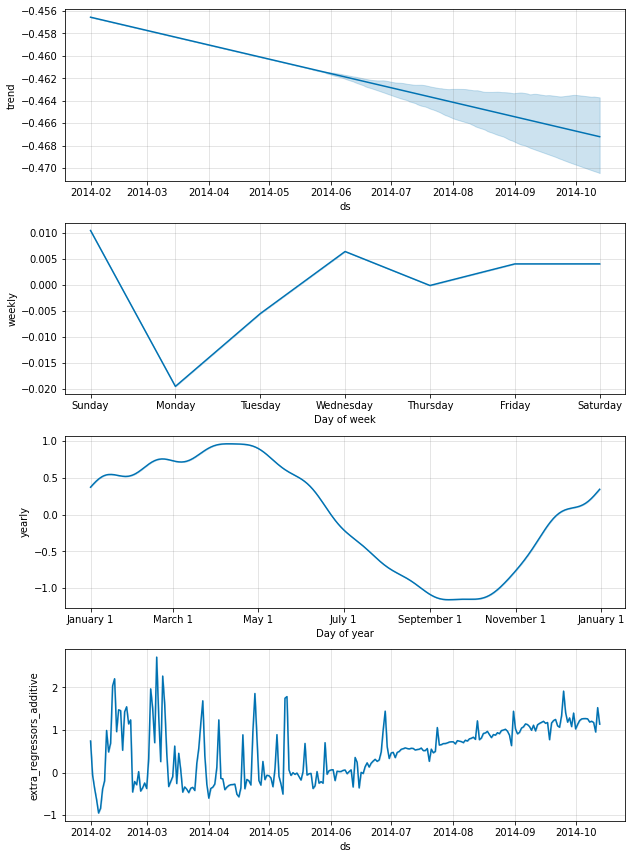

In [ ]:
fig1 = m.plot_components(forecast1)

####6.4.5 Model Error


In [ ]:
error_prophet= rmse(final_prophet['y'], final_prophet['yhat'])
print("Model error for Prophet is ", str(error_prophet))

Model error for Prophet is  0.5031214170659976
